# An exploratory analysis on stock prices

### Disclaimer! 
 ### We are not financial advisors! Investments come with risks and should be supplemented with additional research on top of our findings. Our findings are purely for educational purposes.


For this project, we will conduct an analysis on stock prices in various sectors and our main focus is to <b> determine if a particular stock is suitable for either a long-term or as a short-term investment.</b>

We will also be attempting to answer the following questions:

1) what is the stock price affected by? <br>
2) how can we predict stock prices?


## Determining long-term or short-term investment
To determine if a particular stock is better for long-term or short-term investment, we will attempt to predict the stock prices for different timeframes. Typically a short-term investment is meant to be sold within a year while long-term investments are thought to be held for as long as 50 years. However, these ranges are often subjective. Maybe <b>you</b> could provide us with the ranges:
(the following dynamic elements may require you to run this notebook on jupyter)

### What are your ranges?

In [1]:
from ipywidgets import interact, widgets

print('Short-term definition: ')

short_term = widgets.IntSlider(min = 1,max = 12, step = 1, description = 'month (s)')
display(short_term)

print('Long-term definition: ')

long_term = widgets.IntSlider(min = 1,max = 50, step = 1, description = 'year (s)')
display(long_term)




Short-term definition: 


IntSlider(value=1, description='month (s)', max=12, min=1)

Long-term definition: 


IntSlider(value=1, description='year (s)', max=50, min=1)

### Predicting Stock Prices

As we are trying to predict future prices, we will need to do timeseries forecasting. This can be done using the ARIMA model. ARIMA is similar to linear regression, except this time the predictors are the past values of our response variable. 



### Pick a stock:

In [2]:
company_name = widgets.Dropdown(options = ['Google-GOOGL','Apple-AAPL','Boeing-BA','Visa-V'],description = 'Company: ',disabled = False) 
display(company_name)

Dropdown(description='Company: ', options=('Google-GOOGL', 'Apple-AAPL', 'Boeing-BA', 'Visa-V'), value='Google…

NOTE: The initial part of our project is dynamic, however when running our results, we used Google as the "test set".

### Now lets retrieve our data!

In [3]:
import requests
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import time
import os

In [4]:
# YOUR API KEY HERE
key = ''

name = company_name.value.split('-')[1]
monthly_data = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={}&apikey={}&datatype=csv'.format(name,key))

daily_data = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}&datatype=csv&outputsize=full'.format(name,key))


monthly_data.head()

timestamp      open     high        low    close  adjusted close  \
0  2021-04-20  2092.250  2304.09  2091.4300  2279.01         2279.01   
1  2021-03-31  2048.000  2113.74  1994.0000  2062.52         2062.52   
2  2021-02-26  1844.585  2145.14  1844.5850  2021.91         2021.91   
3  2021-01-29  1760.000  1932.08  1696.1014  1827.36         1827.36   
4  2020-12-31  1766.655  1843.83  1694.0000  1752.64         1752.64   

     volume  dividend amount  
0  19115877              0.0  
1  37837953              0.0  
2  33609952              0.0  
3  39569373              0.0  
4  30424255              0.0

# ARIMA 

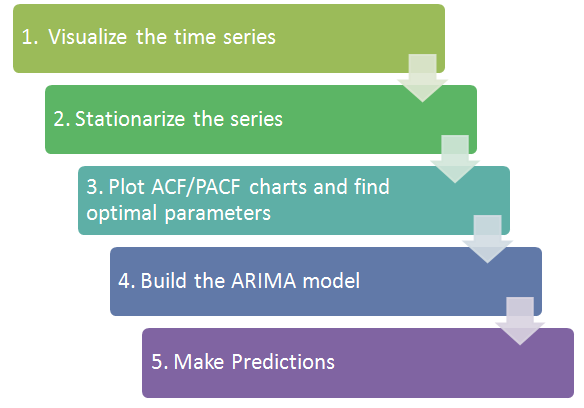

### Extract relevant columns. We will attempt to predict stock price during peace time(before covid and after financial crisis) for better results.

In [5]:
data = monthly_data.set_index("timestamp").copy(deep=True)
data = data.sort_values(by=["timestamp"])
adj_close = pd.DataFrame(data["adjusted close"])
adj_close = adj_close["2010-01-01":"2018-12-31"]
adj_close.head()

adjusted close
timestamp                 
2010-01-29        265.7925
2010-02-26        264.2156
2010-03-31        284.4380
2010-04-30        263.6614
2010-05-28        243.5669

## CANDLESTICK VISUALISATION

In [6]:
import plotly.graph_objects as go
from datetime import datetime

def candlestick_figure(df): #df is the data with timestamp, open, high, low and close data
   
    fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['adjusted close'])])
    
    fig.update_layout(title={'text': "Candlestick",
                             'y':0.9,
                             'x':0.49,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      xaxis_title="Timestamp",
                      yaxis_title="price",
                      legend_title="Legend Title",
                      font=dict(family="Times New Roman, monospace",
                                size=18,color="Black"))
    
    fig.show()
    
    
candlestick_figure(monthly_data)

#### The plot is dynamic, it can be moved by the user, hovering over the candlesticks will give you open,low,close and high data.

# Time series visualisation of adjusted close

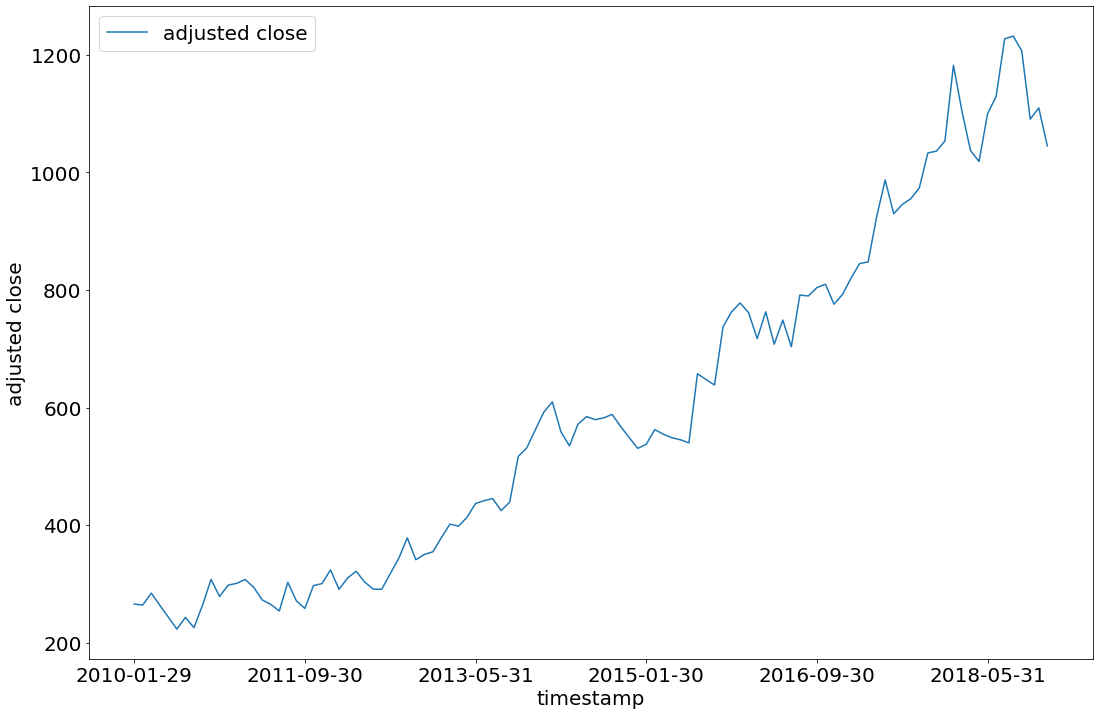

In [7]:
adj_close.plot(figsize=(18,12),fontsize=20)
plt.ylabel("adjusted close",fontsize=20)
plt.xlabel("timestamp",fontsize=20)
plt.legend(fontsize=20)

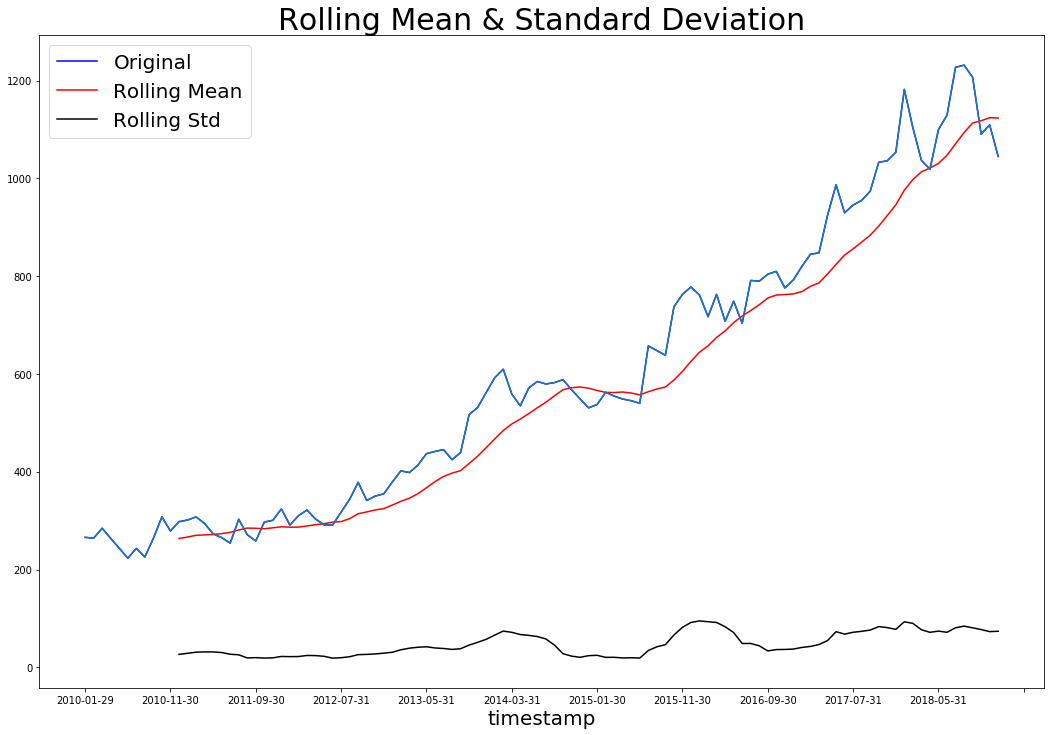

In [8]:
#Determining rolling statistics
rolling_mean = adj_close.rolling(window=12).mean()
rolling_std = adj_close.rolling(window=12).std()
#print(rolling_mean,rolling_std)

#Plot rolling statistics
f, axes = plt.subplots(1, 1, figsize=(18, 12))
orig = plt.plot(adj_close,color = "blue",label = "Original")
mean = plt.plot(rolling_mean,color = "red",label = "Rolling Mean")
std = plt.plot(rolling_std,color = "black",label = "Rolling Std")
plt.legend(loc="best",fontsize=20)
plt.xlabel("timestamp",fontsize=20)
plt.title("Rolling Mean & Standard Deviation",fontsize=30)
x = adj_close.index
plt.xticks(np.arange(0, 469, 10))
plt.plot(x,adj_close)

From the graph, we can see rolling mean is a trend component too, even though rolling standard deviation is fairly constant with time. For stationarity, both rolling mean and rolling standard deviation must remain time invariant. Thus the curves, for stationarity, have to be relatively parallel to the x-axis, which in our case is not so.

To further confirm, that the series is indeed non-stationary we use the ADFuller Test!

In [9]:
#Check to see if time series graph is stationary
#A stationary series is one where the properties do not change over time.
#Perform Dickey-Fuller test:

from statsmodels.tsa.stattools import adfuller

print("Results of Dickey-Fuller Test:")
DF_test = adfuller(adj_close,autolag="AIC")
DF_output = pd.Series(DF_test[0:4],index=["Test Statistics","p-value","#Lags Used","Number of Observations Used"])
for key,value in DF_test[4].items():
    DF_output["Critical value (%s)" %key] = value

print(DF_output)

Results of Dickey-Fuller Test:
Test Statistics                 1.194890
p-value                         0.995950
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical value (1%)            -3.500379
Critical value (5%)            -2.892152
Critical value (10%)           -2.583100
dtype: float64


The output above shows that the p-value is greater than the significance level of 0.05, so we fail to reject the null hypothesis. The series is not stationary and requires differencing.
<br>
<br>
The data is not stationary because the moving average is increasing with time. Therefore we need to do differencing to make it stationary

## Differencing to make time series stationary
<br>
<br>
1st method: log scale transform

Text(0.5, 1.0, 'Log Scale adjusted close')

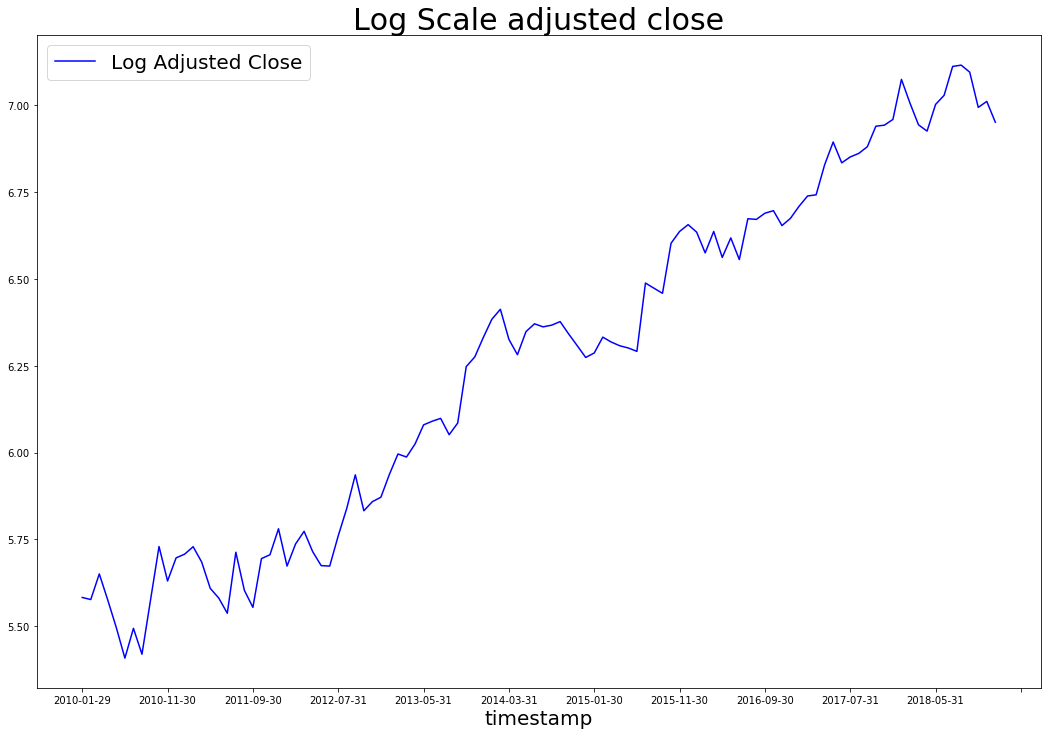

In [10]:
#Estimating trend using Log 
f, axes = plt.subplots(1, 1, figsize=(18, 12))
adj_close_log = np.log(adj_close)
x = adj_close_log.index
plt.xticks(np.arange(0, 469, 10))
plt.xlabel("timestamp",fontsize=20)
plt.plot(x,adj_close_log,color="blue",label="Log Adjusted Close")
plt.legend(loc="best",fontsize=20)
plt.title("Log Scale adjusted close",fontsize=30)

### Function to test for stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    f, axes = plt.subplots(1, 1, figsize=(18, 12))
    orig = plt.plot(timeseries,color = "blue",label = "Original")
    mean = plt.plot(movingAverage,color = "red",label = "Rolling Mean")
    std = plt.plot(movingSTD,color = "black",label = "Rolling Std")
    plt.legend(loc="best",fontsize=20)
    plt.xlabel("timestamp",fontsize=20)
    plt.title("Rolling Mean & Standard Deviation",fontsize=30)
    x = timeseries.index
    plt.xticks(np.arange(0, 469, 10))
    plt.plot(x,timeseries)
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    DF_test = adfuller(timeseries["adjusted close"],autolag="AIC")
    DF_output = pd.Series(DF_test[0:4],index=["Test Statistics","p-value","#Lags Used","Number of Observations Used"])
    for key,value in DF_test[4].items():
        DF_output["Critical value (%s)" %key] = value
        
        
    print(DF_output)
    

### To Test for Stationarity:

1) Moving Average
<br>
3) Shifiting

### Stationarity means:

1) Constant mean
<br>
2) Constant Variance
<br>
3) Autocovariance that does not depend on time


To determine if timeseries is stationary, using DF test:<br>
<br>
Case 1) significance level > 0.05, we fail to reject the null hypothesis. The series is not stationary and requires differencing.

<br>
Case 2) significance level <0.05, we reject the null hypothesis. The series is stationary





## With moving average

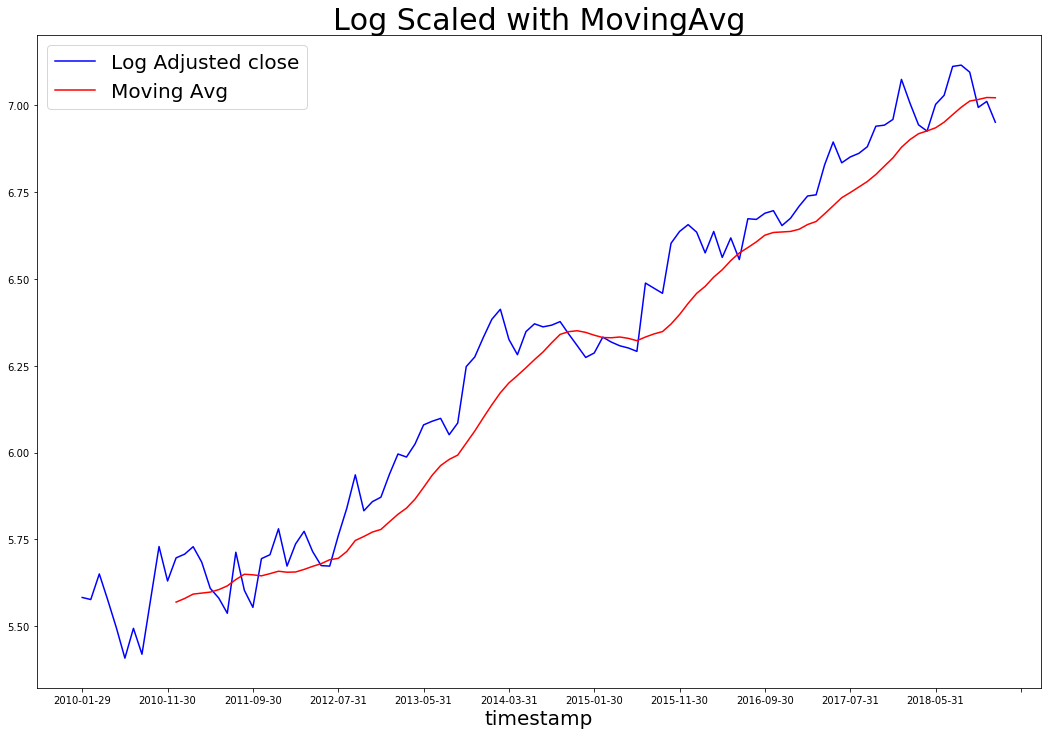

In [12]:
f, axes = plt.subplots(1, 1, figsize=(18, 12))
moving_average = adj_close_log.rolling(window=12).mean()
#moving_std = adj_close_log.rolling(window=12).std()
plt.xticks(np.arange(0, 469, 10))
plt.xlabel("timestamp",fontsize=20)
plt.title("Log Scaled with MovingAvg",fontsize=30)
plt.plot(adj_close_log,color = "blue",label="Log Adjusted close")
plt.plot(moving_average,color="red",label="Moving Avg")
plt.legend(loc="best",fontsize=20)

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can at least say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component.

In [13]:
ac_log_minus_MA = adj_close_log - moving_average
#Remove Nan values
ac_log_minus_MA.dropna(inplace=True)
ac_log_minus_MA.head(10)

adjusted close
timestamp                 
2010-12-31        0.127420
2011-01-31        0.127724
2011-02-28        0.136529
2011-03-31        0.089290
2011-04-29        0.010940
2011-05-31       -0.024299
2011-06-30       -0.078815
2011-07-29        0.078691
2011-08-31       -0.046363
2011-09-30       -0.093742

Results of Dickey-Fuller Test:
Test Statistics                -3.703454
p-value                         0.004065
#Lags Used                      0.000000
Number of Observations Used    96.000000
Critical value (1%)            -3.500379
Critical value (5%)            -2.892152
Critical value (10%)           -2.583100
dtype: float64


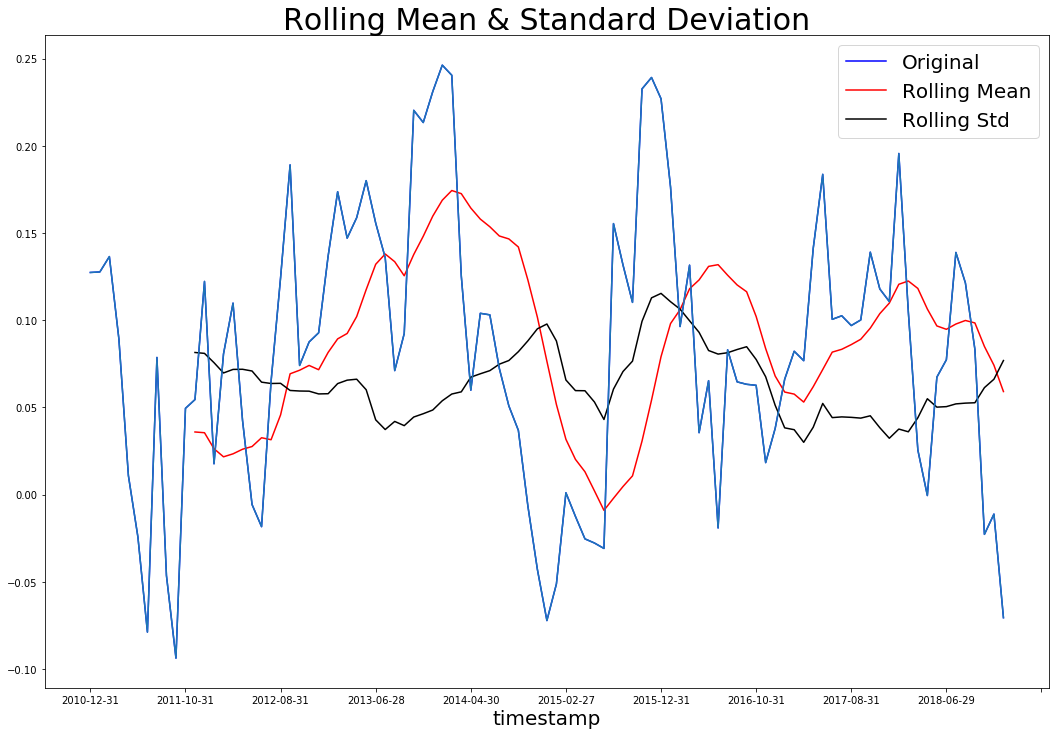

In [14]:
test_stationarity(ac_log_minus_MA)

We can see here, p-value has fell significantly, but the rolling mean still looks trendy. Can we do better?

## Using Shifting

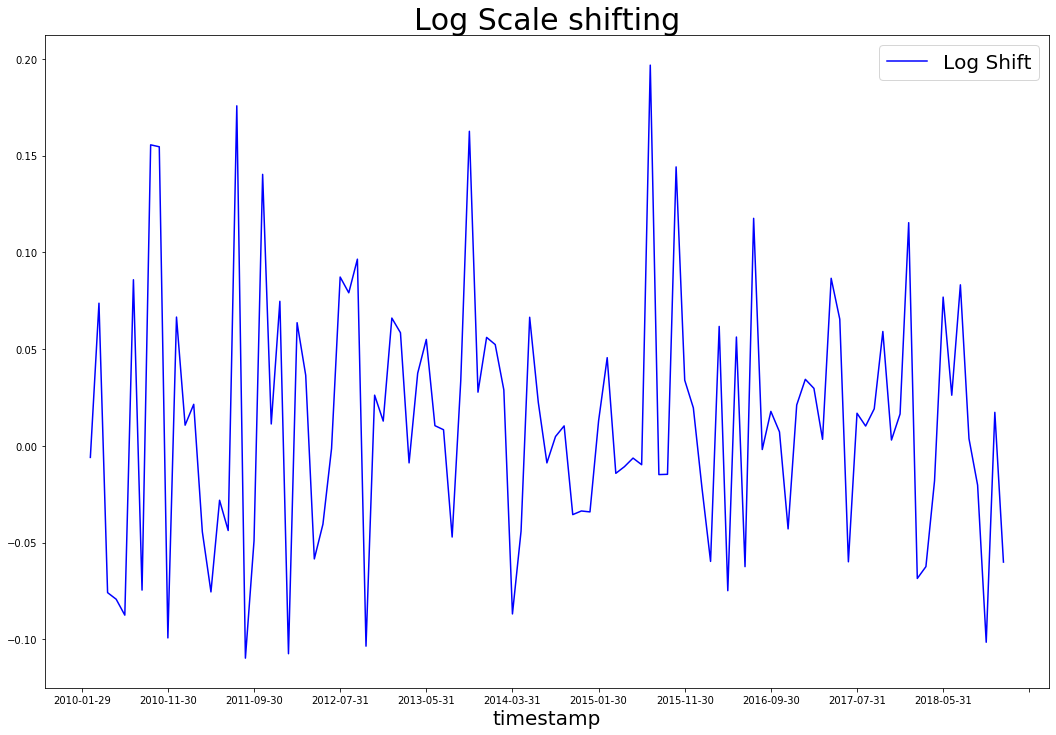

In [15]:
ac_log_shift = adj_close_log - adj_close_log.shift()

f, axes = plt.subplots(1, 1, figsize=(18, 12))
plt.xlabel("timestamp",fontsize=20)
x = adj_close_log.index
plt.xticks(np.arange(0, 469, 10))
plt.plot(x,ac_log_shift,color="blue",label="Log Shift")
plt.title("Log Scale shifting",fontsize=30)
plt.legend(loc="best",fontsize=20)

Results of Dickey-Fuller Test:
Test Statistics               -1.160322e+01
p-value                        2.618297e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.060000e+02
Critical value (1%)           -3.493602e+00
Critical value (5%)           -2.889217e+00
Critical value (10%)          -2.581533e+00
dtype: float64


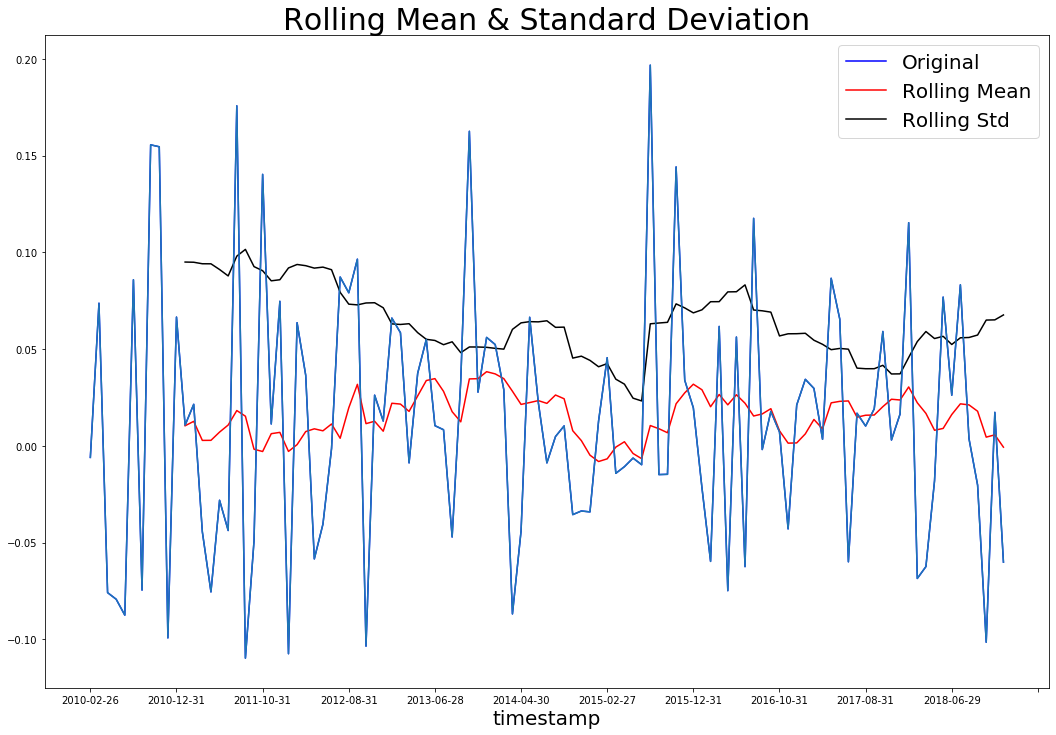

In [16]:
ac_log_shift.dropna(inplace=True)
test_stationarity(ac_log_shift)

From above 2 graphs, we can see that, visually shifting gives us the best result as our series along with rolling statistic values of moving average and moving standard deviation is almost flat stationary. 


For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend and seasonality. 

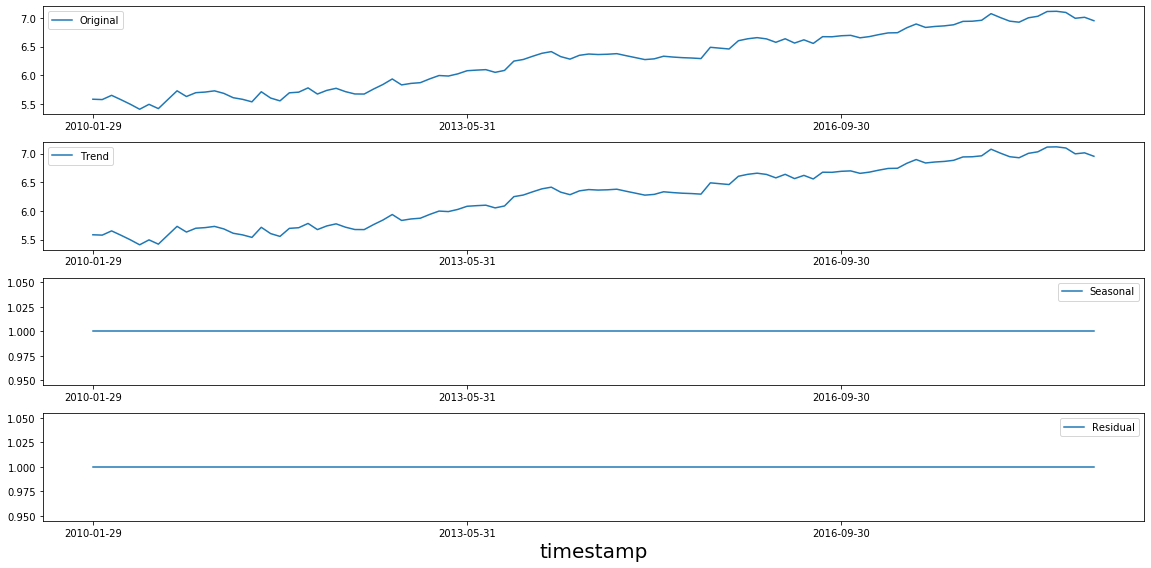

In [17]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition  = seasonal_decompose(adj_close_log,period=1,model = "multiplicative")
plt.rcParams['figure.figsize'] = (16,8)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

x = adj_close_log.index

plt.subplot(411)
plt.plot(x,adj_close_log, label="Original")
plt.legend(loc="best",fontsize=10)
plt.xticks(np.arange(0, 120, 40))

plt.subplot(412)
plt.plot(x,trend, label="Trend")
plt.legend(loc="best",fontsize=10)
plt.xticks(np.arange(0, 120, 40))

plt.subplot(413)
plt.plot(x,seasonal, label="Seasonal")
plt.legend(loc="best",fontsize=10)
plt.xticks(np.arange(0, 120, 40))

plt.subplot(414)
plt.plot(x,residual, label="Residual")
plt.legend(loc="best",fontsize=10)
plt.xticks(np.arange(0, 120, 40))

plt.xlabel("timestamp",fontsize=20)
plt.tight_layout()



Text(0.5, 1.0, 'Autocorrelation Funtion')

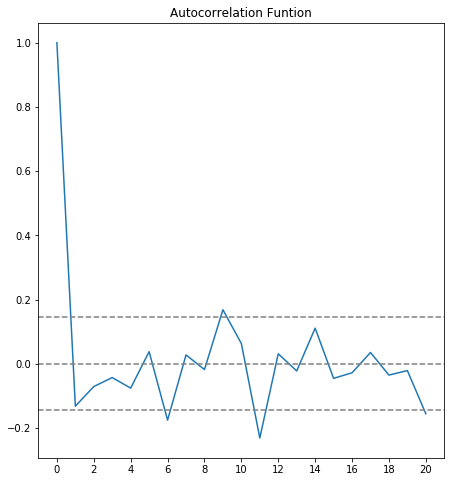

In [18]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf,pacf
import warnings
warnings.filterwarnings("ignore")

lag_acf = acf(ac_log_shift, nlags=20)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
x = [0,5,10,15,20]
plt.xticks(np.arange(min(x), max(x)+1, 2))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.5/np.sqrt(len(ac_log_shift)),linestyle='--',color='gray')
plt.axhline(y=1.5/np.sqrt(len(ac_log_shift)),linestyle='--',color='gray')
plt.title("Autocorrelation Funtion")




Text(0.5, 1.0, 'Partial Autocorrelation Funtion')

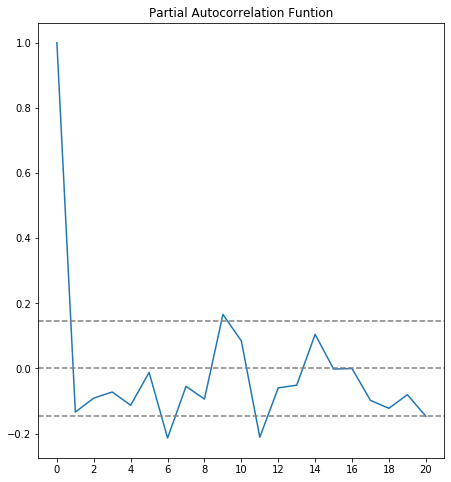

In [19]:
lag_pacf = pacf(ac_log_shift, nlags=20, method='ols')

#Plot PACF:
plt.subplot(121)
plt.plot(lag_pacf)
x = [0,5,10,15,20]
plt.xticks(np.arange(min(x), max(x)+1, 2))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.5/np.sqrt(len(ac_log_shift)),linestyle='--',color='gray')
plt.axhline(y=1.5/np.sqrt(len(ac_log_shift)),linestyle='--',color='gray')
plt.title("Partial Autocorrelation Funtion")

From the ACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, Q = 1.
From the PACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, P = 1.

### AR of ARIMA

Plotting AR model


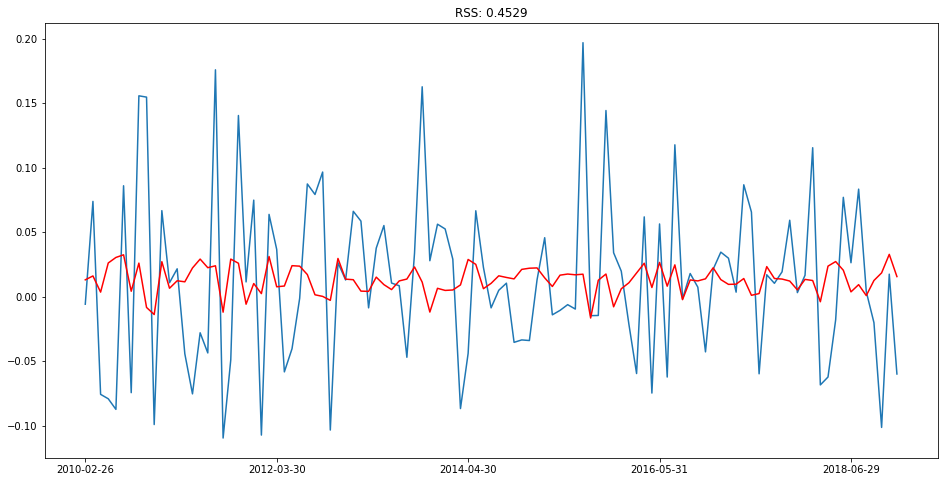

In [20]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model
AR_model = ARIMA(adj_close_log, order=(0,1,1)) #p,d,q
results_AR = AR_model.fit(disp=-1)
plt.plot(ac_log_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title("RSS: %.4f"% sum((results_AR.fittedvalues-ac_log_shift["adjusted close"])**2))
x = ac_log_shift.index
plt.xticks(np.arange(0, 120, 25))
print("Plotting AR model")

### MA of ARIMA

Plotting MA model


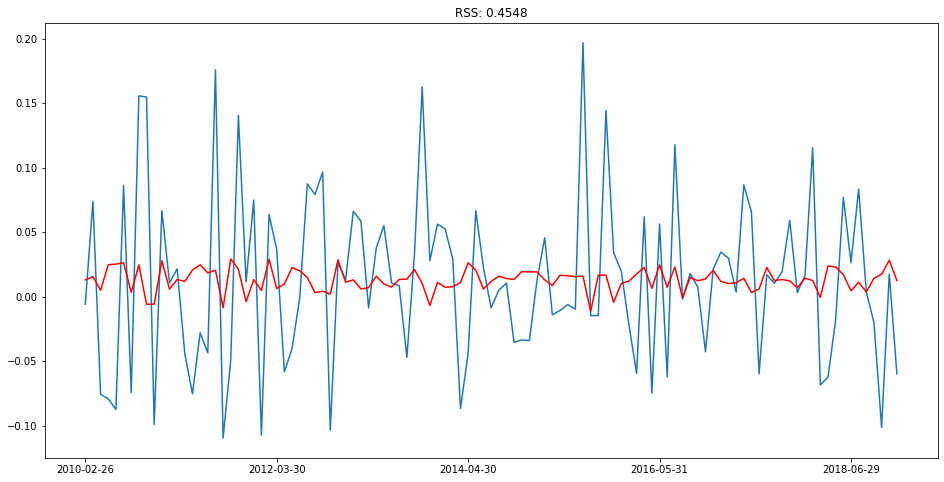

In [21]:
#MA model
MA_model = ARIMA(adj_close_log, order=(1,1,0)) 
results_MA = MA_model.fit(disp=-1)
plt.plot(ac_log_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title("RSS: %.4f"% sum((results_MA.fittedvalues-ac_log_shift["adjusted close"])**2))
x = ac_log_shift.index
plt.xticks(np.arange(0, 120, 25))
print("Plotting MA model")



Plotting ARIMA model


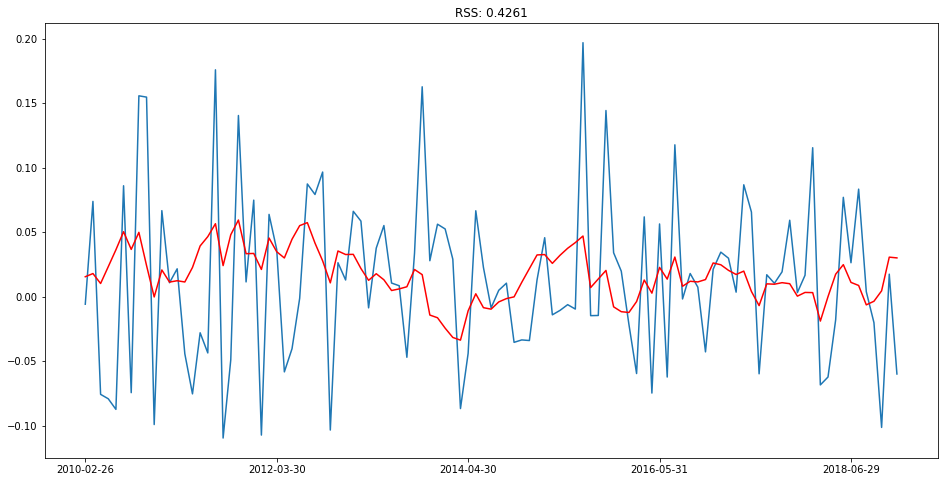

In [22]:
#ARIMA Model
ARIMA_model = ARIMA(adj_close_log, order=(1,1,1))
results_ARIMA = ARIMA_model.fit(disp=-1)
plt.plot(ac_log_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title("RSS: %.4f"% sum((results_ARIMA.fittedvalues-ac_log_shift["adjusted close"])**2))
x = ac_log_shift.index
plt.xticks(np.arange(0, 120, 25))
print("Plotting ARIMA model")

By combining AR and MA into ARIMA, we see that RSS value has decreased from both AR and MA to 0.4261, indicating ARIMA to be better than its individual component models.

## Taking results back to the original scale

In [23]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())
#Second column is the predictions

timestamp
2010-02-26    0.015346
2010-03-31    0.017811
2010-04-30    0.010095
2010-05-28    0.023128
2010-06-30    0.036234
dtype: float64


In [24]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

timestamp
2010-02-26    0.015346
2010-03-31    0.033158
2010-04-30    0.043253
2010-05-28    0.066380
2010-06-30    0.102614
dtype: float64


In [25]:
predictions_ARIMA_log = pd.Series(adj_close_log["adjusted close"].iloc[0],index=adj_close_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

timestamp
2010-01-29    5.582716
2010-02-26    5.598062
2010-03-31    5.615874
2010-04-30    5.625969
2010-05-28    5.649096
dtype: float64

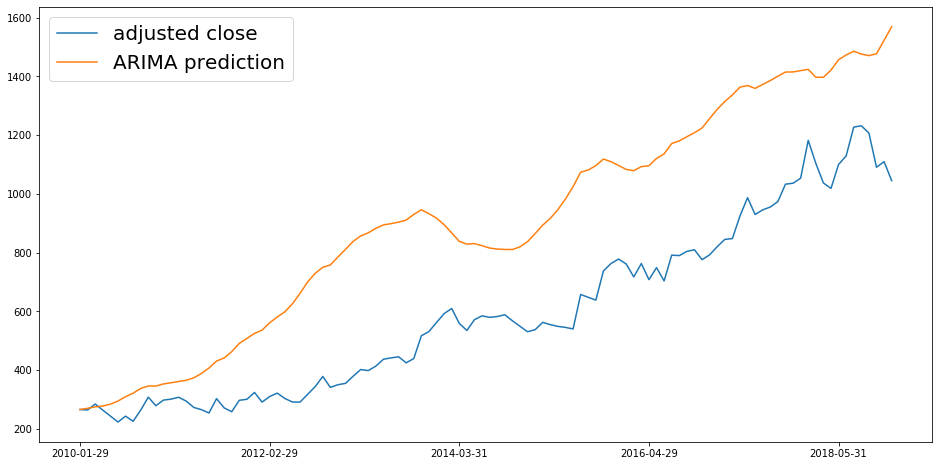

In [26]:
predictions_ARIMA = np.exp(predictions_ARIMA_log) # Get data in original format
x = adj_close.index
plt.xticks(np.arange(0, 120, 25))
plt.plot(adj_close, label='adjusted close')
plt.plot(predictions_ARIMA,label = 'ARIMA prediction')
plt.legend(loc='best',fontsize = 20)

Based on test case, our predicted forecast is generally higher than adjusted close but follows the same trend, maybe if we can have a function to scale this down, we will have a perfect model. However, the results are still appreciable!

## Now, let's see how this stock performs after your chosen timeframe for long-term!

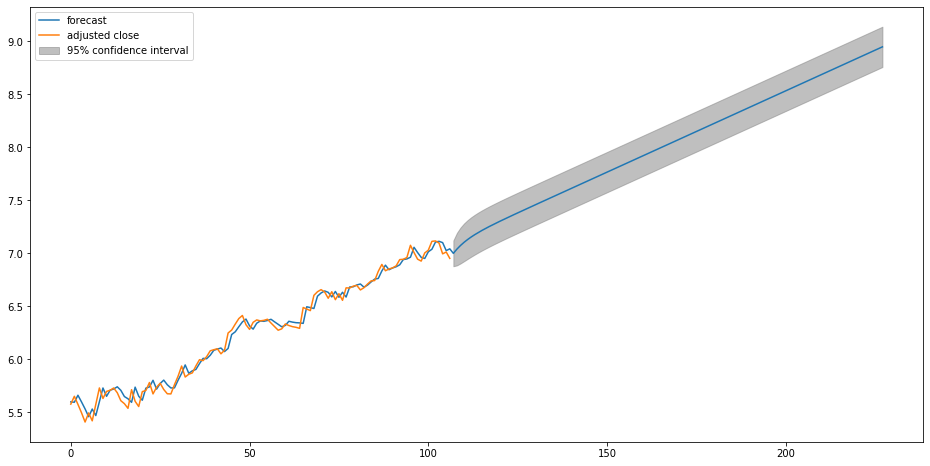

In [27]:
s = 12 * long_term.value
temp =  adj_close_log.shape[0] + s
results_ARIMA.plot_predict(1,temp)
y =results_ARIMA.forecast(steps=s) # Predict given years

## Now, let's see how this stock performs after your chosen timeframe for short-term!

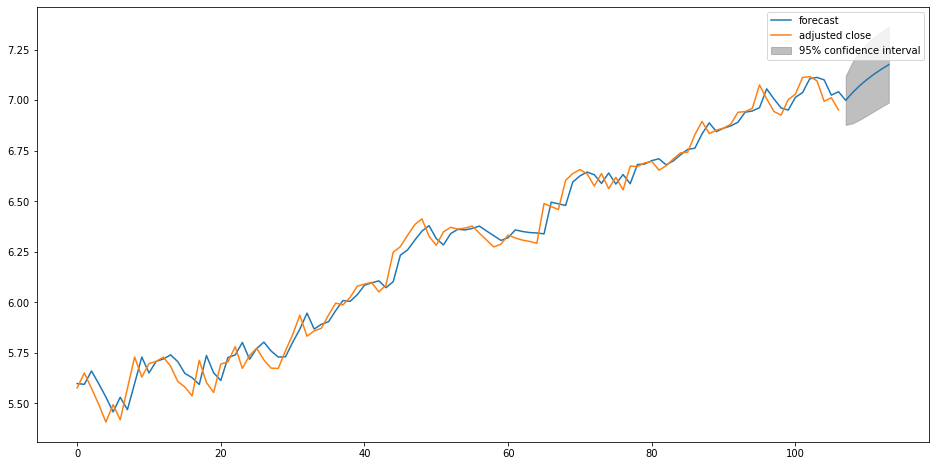

In [28]:
s = short_term.value
temp =  adj_close_log.shape[0] + s
results_ARIMA.plot_predict(1,temp)
y =results_ARIMA.forecast(steps=s) # Predict given years

Based on a sample test case(Google), the stock is good for both long and short term investments!

As we can see, ARIMA is able to help us get a rough estimate of the trend but what if we want to see a more detailed price prediction? Can we do better with just past stock prices alone?

## Enter LSTM
To get a more accurate prediction, we can employ the help of neural networks like LSTM. LSTM thrives when fed with <b>large</b> sets of data as it 'remembers' past data and uses it to predict the future. We will feed it with daily adjusted close since we have more datapoints compared to monthly adjusted close. You can visually see the difference in detail below!

In [29]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
import warnings

def predict(df,past_days,future_days, daily): 

    df = df.set_index('timestamp')
    df = df.sort_values(by=['timestamp'])
    df = df["2010-01-01":"2018-12-31"]
    df = df.reset_index(level='timestamp', col_level=1)
    df.head(10)

    #Separate dates for future plotting
    train_dates = pd.to_datetime(df['timestamp'])

    #Variables for training
    # open,high,low,close,adjusted close,volume
    cols = list(df)[1:6]
    df_train = df[cols].astype(float)
    df_train.head()

    df_train.shape

    # Scale the Data
    scaler = StandardScaler()
    scaler = scaler.fit(df_train)
    df_train_scaled = scaler.transform(df_train)

    df_train_scaled.shape

    #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 

    trainX = []
    trainY = []

    n_future = 1   # Number of days we want to predict into the future
    n_past = past_days     # Number of past days we want to use to predict the future

    for i in range(n_past, len(df_train_scaled) - n_future +1):
        trainX.append(df_train_scaled[i - n_past:i, 0:df_train.shape[1]])
        trainY.append(df_train_scaled[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape)) #Size 1 because its predicting the day after

    # define Autoencoder model

    model = Sequential()
    model.add(LSTM(64,activation = 'relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(32 ,activation = 'relu', return_sequences=False))

    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()

    #fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

    #Forecasting...
    #Start with the last day in training date and predict future...
    n_future= future_days  #Redefining n_future to extend prediction dates beyond original n_future dates...
    forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

    forecast = model.predict(trainX[-n_future:]) #forecast #Scaled values

    forecast.shape

    #Perform inverse transformation to rescale back to original range
    #Since we used 5 variables for transform, the inverse expects same dimensions
    #Therefore, let us copy our values 5 times and discard them after inverse transform
    forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

    # Convert timestamp to date
    forecast_dates = []
    for time_i in forecast_period_dates:
        forecast_dates.append(time_i.date())

        
    hack = 'adjusted_close' if daily == True else 'adjusted close'
    
    df_forecast = pd.DataFrame({'timestamp':np.array(forecast_dates), hack:y_pred_future})
    df_forecast['timestamp']=pd.to_datetime(df_forecast['timestamp'])

    warnings.filterwarnings("ignore")
    original = df[["timestamp", hack]]
    original['timestamp']=pd.to_datetime(original['timestamp'])
    original = original.loc[original['timestamp'] >= '2010-01-01']
    
    plt.rcParams['figure.figsize'] = (16,8)
    sns.lineplot(original['timestamp'], original[hack], label = 'adjusted close actual')
    sns.lineplot(df_forecast['timestamp'], df_forecast[hack],label = 'adjusted close forecast')
    plt.legend(fontsize = 20)

Using TensorFlow backend.


trainX shape == (2234, 30, 5).
trainY shape == (2234, 1).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            17920     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Train on 2010 samples, validate on 224 samples
Epoch 1/10
2010/2010 [==============================] - 3s 1ms/step - loss: 0.1627 - val_loss: 0.0341
Epoch 2/10
2010/2010 [===================

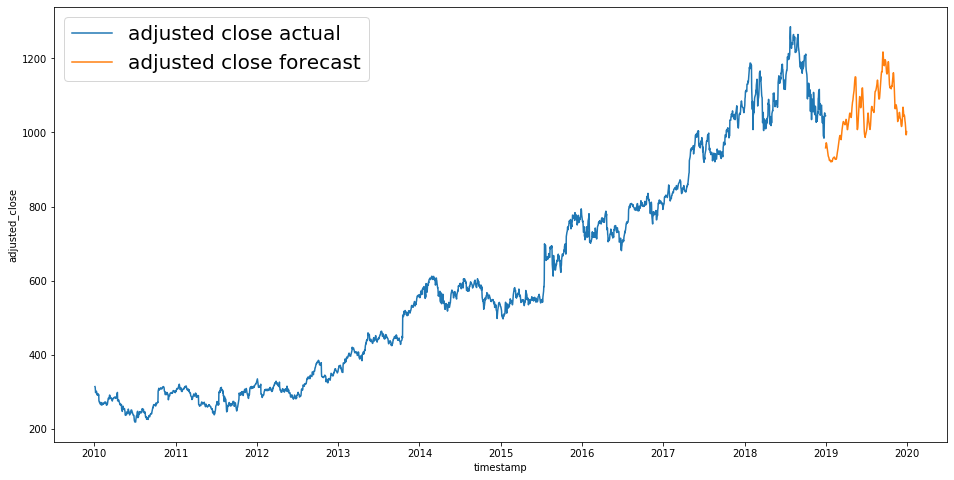

In [30]:
predict(daily_data,30,365, True)

Based on our sample test case(Google), we are able to see fluctuations. Looks good for long term, but in the short term you need to be aware of the expected fall!

<br><br>

# Exploring relationship between company fundamentals and adjusted close

Now, we are interested to know if there are quantifiable factors that can affect a stock's price. Alphavantage provides additional fundamental data for companies. These include :
cashflow, earnings, income statement, balance sheet.

<b>Note: From this part of the notebook onwards, the dataset is no longer dynamic and we assume Google(GOOGL) as the working dataset for showcase.</b>

### Data Cleaning
We will also need to do some cleaning. We will need to drop columns that contain no information for all rows, and also convert to correct datatypes.


In [31]:
import json

pd.set_option('display.max_columns',500)

with open('GOOGLCashFlow.json') as f:
  cashflowData = json.load(f)

with open('GOOGLIncome.json') as f:
  incomeData = json.load(f)

with open('GOOGLBalanceSheet.json') as f:
  balanceSheetData = json.load(f)

with open('GOOGLEPS.json') as f:
  earningsData = json.load(f)

incomeData = incomeData['quarterlyReports']
incomeData = pd.DataFrame(incomeData)

balanceSheetData = balanceSheetData['quarterlyReports']
balanceSheetData = pd.DataFrame(balanceSheetData)

earningsData = earningsData['quarterlyEarnings']
earningsData = pd.DataFrame(earningsData)

cashflowData = cashflowData['quarterlyReports']
cashflowData = pd.DataFrame(cashflowData)
cashflowData.head()


fiscalDateEnding reportedCurrency operatingCashflow  \
0       2020-12-31              USD       22677000000   
1       2020-09-30              USD       17003000000   
2       2020-06-30              USD       13993000000   
3       2020-03-31              USD       11451000000   
4       2019-12-31              USD       14427000000   

  paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                      554000000                            None   
1                      527000000                            None   
2                      493000000                            None   
3                      430000000                            None   
4                      449000000                            None   

  changeInOperatingLiabilities changeInOperatingAssets  \
0                   5783000000              6183000000   
1                   3690000000              3834000000   
2                   1689000000               324000000   
3                  -4329000000             -2487000000   
4                   5243000000              4199000000   

  depreciationDepletionAndAmortization capitalExpenditures  \
0                           3725000000          5479000000   
1                           3478000000          5406000000   
2                           3386000000          5391000000   
3                           3108000000          6005000000   
4                           3413000000          6052000000   

  changeInReceivables changeInInventory   profitLoss cashflowFromInvestment  \
0          5445000000              None  15227000000            -7281000000   
1          3601000000              None  11247000000           -15197000000   
2            80000000              None   6959000000            -8448000000   
3         -2602000000              None   6836000000            -1847000000   
4          4365000000              None  10671000000            -4703000000   

  cashflowFromFinancing proceedsFromRepaymentsOfShortTermDebt  \
0           -9270000000                                  None   
1             546000000                                  None   
2           -7498000000                                  None   
3           -8186000000                                  None   
4           -7326000000                                  None   

  paymentsForRepurchaseOfCommonStock paymentsForRepurchaseOfEquity  \
0                         7904000000                    7904000000   
1                         7897000000                    7897000000   
2                         6852000000                    6852000000   
3                         8496000000                    8496000000   
4                         6098000000                    6098000000   

  paymentsForRepurchaseOfPreferredStock dividendPayout  \
0                                  None           None   
1                                  None           None   
2                                  None           None   
3                                  None           None   
4                                  None           None   

  dividendPayoutCommonStock dividendPayoutPreferredStock  \
0                      None                         None   
1                      None                         None   
2                      None                         None   
3                      None                         None   
4                      None                         None   

  proceedsFromIssuanceOfCommonStock  \
0                              None   
1                              None   
2                              None   
3                              None   
4                              None   

  proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet  \
0                                               None          
1                                               None          
2                                               None          
3                                           

In [32]:

counter = 0 

# only set to 0 for cols that are supposed to be numeric
for col in cashflowData:
    counter += 1
    if(counter >= 3):
        cashflowData[col].replace('None', 0, inplace = True)
        

cashflowData.drop(columns=['reportedCurrency'], inplace=True)

        
cashflowData = cashflowData.astype({'operatingCashflow': 'int64', 'changeInOperatingLiabilities': 'int64',
                                    'changeInOperatingAssets': 'int64', 'depreciationDepletionAndAmortization': 'int64',
                                    'capitalExpenditures': 'int64', 'changeInReceivables': 'int64',
                                    'changeInInventory': 'int64', 'profitLoss': 'int64',
                                    'cashflowFromInvestment': 'int64', 'paymentsForOperatingActivities': 'int64',
                                    'proceedsFromOperatingActivities': 'int64','proceedsFromRepaymentsOfShortTermDebt': 'int64',
                                    'paymentsForRepurchaseOfCommonStock': 'int64','paymentsForRepurchaseOfEquity': 'int64',
                                    'paymentsForRepurchaseOfPreferredStock': 'int64','dividendPayoutPreferredStock': 'int64',
                                    'proceedsFromIssuanceOfCommonStock': 'int64','proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet': 'int64',
                                    'proceedsFromIssuanceOfPreferredStock': 'int64','proceedsFromSaleOfTreasuryStock': 'int64','changeInExchangeRate': 'int64',
                                    'cashflowFromFinancing': 'int64',
                                    'dividendPayoutCommonStock': 'int64',
                                    'proceedsFromRepurchaseOfEquity': 'int64', 'changeInCashAndCashEquivalents': 'int64',
                                    'netIncome': 'int64','dividendPayout': 'int64'})

cashflowData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 28 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   fiscalDateEnding                                           20 non-null     object
 1   operatingCashflow                                          20 non-null     int64 
 2   paymentsForOperatingActivities                             20 non-null     int64 
 3   proceedsFromOperatingActivities                            20 non-null     int64 
 4   changeInOperatingLiabilities                               20 non-null     int64 
 5   changeInOperatingAssets                                    20 non-null     int64 
 6   depreciationDepletionAndAmortization                       20 non-null     int64 
 7   capitalExpenditures                                        20 non-null     int64 
 8   changeInReceivables   

In [33]:

cashflowData.drop(columns=['proceedsFromOperatingActivities','changeInInventory','proceedsFromSaleOfTreasuryStock', 'paymentsForRepurchaseOfPreferredStock','dividendPayout', 'dividendPayoutCommonStock','dividendPayoutPreferredStock','proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet','proceedsFromIssuanceOfPreferredStock'], inplace=True)
cashflowData.head(n=200)

fiscalDateEnding  operatingCashflow  paymentsForOperatingActivities  \
0        2020-12-31        22677000000                       554000000   
1        2020-09-30        17003000000                       527000000   
2        2020-06-30        13993000000                       493000000   
3        2020-03-31        11451000000                       430000000   
4        2019-12-31        14427000000                       449000000   
5        2019-09-30        15466000000                       442000000   
6        2019-06-30        12627000000                       396000000   
7        2019-03-31        12000000000                       374000000   
8        2018-12-31        12987000000                               0   
9        2018-09-30        13210000000                               0   
10       2018-06-30        10132000000                               0   
11       2018-03-31        11642000000                               0   
12       2017-12-31        10268000000                               0   
13       2017-09-30         9872000000                               0   
14       2017-06-30         7403000000                               0   
15       2017-03-31         9548000000                               0   
16       2016-12-31         9413000000                               0   
17       2016-09-30         9845000000                               0   
18       2016-06-30         9120000000                               0   
19       2016-03-31         7658000000                               0   

    changeInOperatingLiabilities  changeInOperatingAssets  \
0                     5783000000               6183000000   
1                     3690000000               3834000000   
2                     1689000000                324000000   
3                    -4329000000              -2487000000   
4                     5243000000               4199000000   
5                     1851000000                612000000   
6                     1276000000               1057000000   
7                     -735000000               -907000000   
8                     3030000000               2854000000   
9                     2150000000               1154000000   
10                    5762000000                827000000   
11                    -890000000              -1459000000   
12                    2605000000               3127000000   
13                    1406000000               2782000000   
14                    3655000000               1162000000   
15                   -1654000000              -1139000000   
16                    1230000000               2081000000   
17                    1307000000                168000000   
18                     626000000                835000000   
19                   -1315000000               -818000000   

    depreciationDepletionAndAmortization  capitalExpenditures  \
0                             3725000000           5479000000   
1                             3478000000           5406000000   
2                             3386000000           5391000000   
3                             3108000000           6005000000   
4                             3413000000           6052000000   
5                             2920000000           6732000000   
6                             2835000000           6126000000   
7                             2613000000           4638000000   
8                             2580000000           7081000000   
9                             2355000000           5282000000   
10                            2114000000           5477000000   
11                            1986000000           7299000000   
12                            2026000000           4307000000   
13                            1761000000           3538000000   
14                            1625000000           2831000000   
15                            1503000000           2508000000   
16                            1687000000           3078000000

In [34]:

cashflowData.drop(columns=['proceedsFromRepaymentsOfShortTermDebt'], inplace=True)

cashflowData.head(n=200)

fiscalDateEnding  operatingCashflow  paymentsForOperatingActivities  \
0        2020-12-31        22677000000                       554000000   
1        2020-09-30        17003000000                       527000000   
2        2020-06-30        13993000000                       493000000   
3        2020-03-31        11451000000                       430000000   
4        2019-12-31        14427000000                       449000000   
5        2019-09-30        15466000000                       442000000   
6        2019-06-30        12627000000                       396000000   
7        2019-03-31        12000000000                       374000000   
8        2018-12-31        12987000000                               0   
9        2018-09-30        13210000000                               0   
10       2018-06-30        10132000000                               0   
11       2018-03-31        11642000000                               0   
12       2017-12-31        10268000000                               0   
13       2017-09-30         9872000000                               0   
14       2017-06-30         7403000000                               0   
15       2017-03-31         9548000000                               0   
16       2016-12-31         9413000000                               0   
17       2016-09-30         9845000000                               0   
18       2016-06-30         9120000000                               0   
19       2016-03-31         7658000000                               0   

    changeInOperatingLiabilities  changeInOperatingAssets  \
0                     5783000000               6183000000   
1                     3690000000               3834000000   
2                     1689000000                324000000   
3                    -4329000000              -2487000000   
4                     5243000000               4199000000   
5                     1851000000                612000000   
6                     1276000000               1057000000   
7                     -735000000               -907000000   
8                     3030000000               2854000000   
9                     2150000000               1154000000   
10                    5762000000                827000000   
11                    -890000000              -1459000000   
12                    2605000000               3127000000   
13                    1406000000               2782000000   
14                    3655000000               1162000000   
15                   -1654000000              -1139000000   
16                    1230000000               2081000000   
17                    1307000000                168000000   
18                     626000000                835000000   
19                   -1315000000               -818000000   

    depreciationDepletionAndAmortization  capitalExpenditures  \
0                             3725000000           5479000000   
1                             3478000000           5406000000   
2                             3386000000           5391000000   
3                             3108000000           6005000000   
4                             3413000000           6052000000   
5                             2920000000           6732000000   
6                             2835000000           6126000000   
7                             2613000000           4638000000   
8                             2580000000           7081000000   
9                             2355000000           5282000000   
10                            2114000000           5477000000   
11                            1986000000           7299000000   
12                            2026000000           4307000000   
13                            1761000000           3538000000   
14                            1625000000           2831000000   
15                            1503000000           2508000000   
16                            1687000000           3078000000

In [35]:

for col in earningsData:
    counter += 1
    if(counter >= 3):
        earningsData[col].replace('None', 0, inplace = True)
        

earningsData = earningsData.astype({'reportedEPS': 'float64', 'estimatedEPS': 'float64',
                                    'surprise': 'float64', 'surprisePercentage': 'float64',})
        
earningsData.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fiscalDateEnding    66 non-null     object 
 1   reportedDate        66 non-null     object 
 2   reportedEPS         66 non-null     float64
 3   estimatedEPS        66 non-null     float64
 4   surprise            66 non-null     float64
 5   surprisePercentage  66 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.2+ KB


In [36]:

for col in incomeData:
    counter += 1
    if(counter >= 3):
        incomeData[col].replace('None', 0, inplace = True)
        
incomeData.drop(columns=['reportedCurrency','investmentIncomeNet','depreciation'], inplace=True)

incomeData = incomeData.astype({'grossProfit': 'int64', 'totalRevenue': 'int64',
                                    'costOfRevenue': 'int64', 'costofGoodsAndServicesSold': 'int64',
                                    'operatingIncome': 'int64', 'sellingGeneralAndAdministrative': 'int64',
                                    'researchAndDevelopment': 'int64', 'operatingExpenses': 'int64',
                                    'depreciationAndAmortization': 'int64',
                                    'interestExpense': 'int64','netInterestIncome': 'int64','interestIncome' :'int64',
                                    'nonInterestIncome': 'int64',
                                    'otherNonOperatingIncome': 'int64',
                                    'incomeBeforeTax': 'int64', 'incomeTaxExpense': 'int64',
                                    'interestAndDebtExpense': 'int64', 'netIncomeFromContinuingOperations': 'int64',
                                    'comprehensiveIncomeNetOfTax': 'int64', 'ebit': 'int64',
                                    'ebitda': 'int64', 'netIncome': 'int64'})

incomeData.head()

fiscalDateEnding  grossProfit  totalRevenue  costOfRevenue  \
0       2020-12-31  30038000000   56118000000    26080000000   
1       2020-09-30  25211000000   46328000000    21117000000   
2       2020-06-30  20195000000   38748000000    18553000000   
3       2020-03-31 -18852000000   41289000000    18982000000   
4       2019-12-31  24185000000   45205000000    21020000000   

   costofGoodsAndServicesSold  operatingIncome  \
0                 26080000000      15651000000   
1                 21117000000      11213000000   
2                 18553000000       6383000000   
3                 18982000000       7977000000   
4                 21020000000       9266000000   

   sellingGeneralAndAdministrative  researchAndDevelopment  operatingExpenses  \
0                       8145000000              7022000000        15167000000   
1                       6987000000              6856000000        13843000000   
2                       6486000000              6875000000        13361000000   
3                       7380000000              6820000000        14200000000   
4                       8567000000              7222000000        15789000000   

   netInterestIncome  interestIncome  interestExpense  nonInterestIncome  \
0          -53000000       386000000         53000000      -125497000000   
1          -48000000       460000000         48000000        46376000000   
2          -13000000       433000000         13000000        38761000000   
3          -21000000       586000000         21000000        41310000000   
4          -17000000       621000000         17000000      -116329000000   

   otherNonOperatingIncome  depreciationAndAmortization  incomeBeforeTax  \
0               -420000000                   3725000000      18689000000   
1                -88000000                   3478000000      13359000000   
2               -147000000                   3386000000       8277000000   
3                 18000000                   3108000000       7757000000   
4                -72000000                   3413000000      10704000000   

   incomeTaxExpense  interestAndDebtExpense  \
0        3462000000                53000000   
1        2112000000                48000000   
2        1318000000                13000000   
3         921000000                21000000   
4          33000000                17000000   

   netIncomeFromContinuingOperations  comprehensiveIncomeNetOfTax  \
0                        15227000000                  15814000000   
1                        11247000000                  11589000000   
2                         6959000000                   7760000000   
3                         6836000000                   6971000000   
4                        10671000000                  10635000000   

          ebit       ebitda    netIncome  
0  15651000000  19376000000  15227000000  
1  11213000000  14691000000  11247000000  
2   6383000000   9769000000   6959000000  
3   7977000000  11085000000   6836000000  
4   9266000000  12679000000  10671000000

In [37]:
incomeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   fiscalDateEnding                   20 non-null     object
 1   grossProfit                        20 non-null     int64 
 2   totalRevenue                       20 non-null     int64 
 3   costOfRevenue                      20 non-null     int64 
 4   costofGoodsAndServicesSold         20 non-null     int64 
 5   operatingIncome                    20 non-null     int64 
 6   sellingGeneralAndAdministrative    20 non-null     int64 
 7   researchAndDevelopment             20 non-null     int64 
 8   operatingExpenses                  20 non-null     int64 
 9   netInterestIncome                  20 non-null     int64 
 10  interestIncome                     20 non-null     int64 
 11  interestExpense                    20 non-null     int64 
 12  nonInteres

In [38]:

for col in balanceSheetData:
    counter += 1
    if(counter >= 3):
        balanceSheetData[col].replace('None', 0, inplace = True)
        
        

balanceSheetData.drop(columns=['reportedCurrency','accumulatedDepreciationAmortizationPPE','treasuryStock'], inplace=True)


balanceSheetData = balanceSheetData.astype({'totalAssets': 'int64', 'totalCurrentAssets': 'int64',
                                    'cashAndCashEquivalentsAtCarryingValue': 'int64', 'cashAndShortTermInvestments': 'int64',
                                    'inventory': 'int64', 'currentNetReceivables': 'int64',
                                    'totalNonCurrentAssets': 'int64', 'propertyPlantEquipment': 'int64',
                                    'intangibleAssets': 'int64', 'otherCurrentAssets': 'int64','deferredRevenue': 'int64','capitalLeaseObligations': 'int64','currentLongTermDebt': 'int64','longTermDebtNoncurrent': 'int64',
                                    'intangibleAssetsExcludingGoodwill': 'int64',
                                    'goodwill': 'int64', 'investments': 'int64',
                                    'longTermInvestments': 'int64', 'shortTermInvestments': 'int64',
                                    'otherNonCurrrentAssets': 'int64', 'totalLiabilities': 'int64',
                                    'totalCurrentLiabilities': 'int64', 'currentAccountsPayable': 'int64',
                                    'currentDebt': 'int64', 'shortTermDebt': 'int64',
                                    'totalNonCurrentLiabilities': 'int64', 'longTermDebt': 'int64',
                                    'shortLongTermDebtTotal': 'int64', 'otherCurrentLiabilities': 'int64',
                                    'otherNonCurrentLiabilities': 'int64',
                                    'totalShareholderEquity': 'int64',
                                    'retainedEarnings': 'int64', 'commonStock': 'int64',
                                    'commonStockSharesOutstanding': 'int64'})
balanceSheetData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   fiscalDateEnding                       20 non-null     object
 1   totalAssets                            20 non-null     int64 
 2   totalCurrentAssets                     20 non-null     int64 
 3   cashAndCashEquivalentsAtCarryingValue  20 non-null     int64 
 4   cashAndShortTermInvestments            20 non-null     int64 
 5   inventory                              20 non-null     int64 
 6   currentNetReceivables                  20 non-null     int64 
 7   totalNonCurrentAssets                  20 non-null     int64 
 8   propertyPlantEquipment                 20 non-null     int64 
 9   intangibleAssets                       20 non-null     int64 
 10  intangibleAssetsExcludingGoodwill      20 non-null     int64 
 11  goodwill             

Now, we are only interested in how these fundamental data can affect our stock prices(the adjusted close).  We are trying to find out if there is a correlation between the stock price and the other variables. However we do not have enough information as things like cashflow only release quarterly. We can fill the gaps with the latest data available at that point in time by repeating the same information.

In [39]:

# merges 2 dataframes together based on the timestamp and returns the result
# df : the current biggest table
# other : the table u want to merge with
# timestampCol1 & timestampCol2 : name of the columns that the merge is based on
# for eg. combine(originalDataFrame, cashflow, 'timestamp', 'fiscalDateEnding')

def combine(df,other,timestampCol1,timestampCol2):
    
    starting = -1
    
    othercopy = other.copy(deep=True)
    
    othercopy = othercopy.sort_values(by=[timestampCol2])
    othercopy = othercopy.reset_index(drop=True)

    datacopy = df.copy(deep=True)
    
    datacopy = datacopy.sort_values(by=[timestampCol1])
    datacopy = datacopy.reset_index(drop=True)
    
    firstLimiter = othercopy[timestampCol2][0]
    secondLimiter = othercopy[timestampCol2][othercopy.shape[0]-1]

    # create an empty dataframe with only the headers
    result = othercopy.iloc[0:0] 
     
    # some empty
    dummy = othercopy[0:1].copy(deep = True)
    for col in dummy.columns:
        dummy[col].values[:] = 0
        
    empty = dummy.iloc[0]

    # use latest information available
    # doesnt rly matter, gonna throw these rows out anyway
    latest = empty

    for i in datacopy.index:

        found = False

        for j in othercopy.index:
            a1 = int(datacopy[timestampCol1][i].split('-')[0])
            a2 = int(datacopy[timestampCol1][i].split('-')[1])
            b1 = int(othercopy[timestampCol2][j].split('-')[0])
            b2 = int(othercopy[timestampCol2][j].split('-')[1])
            
            
            if a1 == b1:
                if a2 == b2:    
                    temp = othercopy.iloc[j]
                    
                    if a1 >= int(firstLimiter.split('-')[0]) and a2 >= int(firstLimiter.split('-')[1]):
                        
                        
                         # update first valid match
                        starting = 1
                        temp = othercopy.iloc[j]

                        latest = temp
                        
                        result = result.append(temp, ignore_index = True)
                        found = True
                        break
                      

                        

        if found == False:
            if starting == -1 or a1 > int(secondLimiter.split('-')[0]) or (a1 == int(secondLimiter.split('-')[0]) and a2 > int(secondLimiter.split('-')[1])):
                result = result.append(empty,ignore_index = True)
            else:
                result = result.append(latest, ignore_index = True)


    combined = pd.concat([datacopy, result], axis=1)
    
    # filters to the correct scope
    combined.drop(combined[combined[timestampCol2] == 0].index, inplace = True)
    
    return combined



Merge all the variables we want to test with our adjusted close and perform a correlation test

In [40]:
closeData = monthly_data[['timestamp','adjusted close']]
test = combine(closeData, cashflowData, 'timestamp', 'fiscalDateEnding')

test.corr()

adjusted close  operatingCashflow  \
adjusted close                              1.000000           0.837781   
operatingCashflow                           0.837781           1.000000   
paymentsForOperatingActivities              0.799213           0.752994   
changeInOperatingLiabilities                0.334341           0.342620   
changeInOperatingAssets                     0.340514           0.443739   
depreciationDepletionAndAmortization        0.916634           0.870736   
capitalExpenditures                         0.659309           0.667202   
changeInReceivables                         0.307257           0.425393   
profitLoss                                  0.493677           0.705959   
cashflowFromInvestment                     -0.123386          -0.273590   
cashflowFromFinancing                      -0.485665          -0.389776   
paymentsForRepurchaseOfCommonStock          0.837954           0.730276   
paymentsForRepurchaseOfEquity               0.856022           0.763279   
proceedsFromRepurchaseOfEquity             -0.833698          -0.728301   
changeInCashAndCashEquivalents              0.360103           0.381818   
changeInExchangeRate                       -0.087951          -0.052299   
netIncome                                   0.493363           0.705649   

                                      paymentsForOperatingActivities  \
adjusted close                                              0.799213   
operatingCashflow                                           0.752994   
paymentsForOperatingActivities                              1.000000   
changeInOperatingLiabilities                                0.050321   
changeInOperatingAssets                                     0.126805   
depreciationDepletionAndAmortization                        0.903873   
capitalExpenditures                                         0.494887   
changeInReceivables                                         0.137590   
profitLoss                                                  0.535485   
cashflowFromInvestment                                     -0.079665   
cashflowFromFinancing                                      -0.586298   
paymentsForRepurchaseOfCommonStock                          0.889995   
paymentsForRepurchaseOfEquity                               0.890312   
proceedsFromRepurchaseOfEquity                             -0.887700   
changeInCashAndCashEquivalents                              0.236277   
changeInExchangeRate                                        0.028035   
netIncome                                                   0.535930   

                                      changeInOperatingLiabilities  \
adjusted close                                            0.334341   
operatingCashflow                                         0.342620   
paymentsForOperatingActivities                            0.050321   
changeInOperatingLiabilities                              1.000000   
changeInOperatingAssets                                   0.802198   
depreciationDepletionAndAmortization                      0.252206   
capitalExpenditures                                       0.177829   
changeInReceivables                                       0.781253   
profitLoss                                                0.095936   
cashflowFromInvestment                                   -0.250664   
cashflowFromFinancing                                    -0.017130   
paymentsForRepurchaseOfCommonStock                        0.025341   
paymentsForRepurchaseOfEquity                             0.007326   
proceedsFromRepurchaseOfEquity                           -0.025316   
changeInCashAndCashEquivalents                            0.003076   
changeInExchangeRate                                     -0.425956   
netIncome                                                 0.094214   

                                      changeInOperatingAssets  \
adjusted close                                       0.340514   

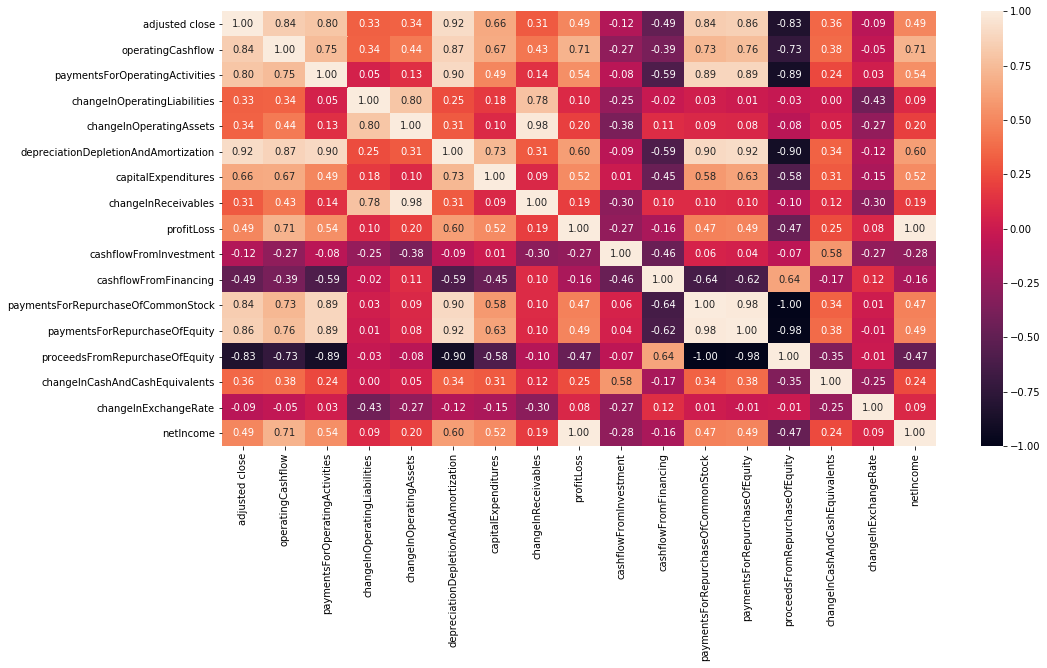

In [41]:
sb.heatmap(test.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

In [42]:
test = combine(closeData, balanceSheetData,'timestamp','fiscalDateEnding')
test.corr()

adjusted close  totalAssets  \
adjusted close                               1.000000     0.933093   
totalAssets                                  0.933093     1.000000   
totalCurrentAssets                           0.930496     0.988525   
cashAndCashEquivalentsAtCarryingValue        0.643401     0.711991   
cashAndShortTermInvestments                  0.924252     0.978037   
inventory                                    0.633826     0.738560   
currentNetReceivables                        0.892462     0.952179   
totalNonCurrentAssets                        0.920063     0.992552   
propertyPlantEquipment                       0.917126     0.973110   
intangibleAssets                             0.674593     0.673792   
intangibleAssetsExcludingGoodwill           -0.910036    -0.984419   
goodwill                                     0.911976     0.933181   
investments                                  0.330608     0.341136   
longTermInvestments                          0.774768     0.834691   
shortTermInvestments                         0.896364     0.953421   
otherCurrentAssets                           0.791305     0.855150   
otherNonCurrrentAssets                      -0.043983    -0.122394   
totalLiabilities                             0.929411     0.990472   
totalCurrentLiabilities                      0.922946     0.984509   
currentAccountsPayable                       0.854325     0.925596   
deferredRevenue                              0.738014     0.804941   
currentDebt                                  0.691853     0.657037   
shortTermDebt                               -0.452344    -0.574070   
totalNonCurrentLiabilities                   0.911916     0.875233   
capitalLeaseObligations                      0.623253     0.548734   
longTermDebt                                 0.711904     0.638752   
currentLongTermDebt                         -0.181065    -0.304439   
longTermDebtNoncurrent                       0.613954     0.543099   
shortLongTermDebtTotal                       0.311999     0.261998   
otherCurrentLiabilities                      0.943311     0.957755   
otherNonCurrentLiabilities                  -0.173060    -0.305548   
totalShareholderEquity                       0.925091     0.995335   
retainedEarnings                             0.907427     0.990285   
commonStock                                  0.942350     0.985931   
commonStockSharesOutstanding                -0.467498    -0.425214   

                                       totalCurrentAssets  \
adjusted close                                   0.930496   
totalAssets                                      0.988525   
totalCurrentAssets                               1.000000   
cashAndCashEquivalentsAtCarryingValue            0.668093   
cashAndShortTermInvestments                      0.995574   
inventory                                        0.774267   
currentNetReceivables                            0.952671   
totalNonCurrentAssets                            0.962787   
propertyPlantEquipment                           0.938000   
intangibleAssets                                 0.602511   
intangibleAssetsExcludingGoodwill               -0.985022   
goodwill                                         0.895403   
investments                                      0.348609   
longTermInvestments                              0.826844   
shortTermInvestments                             0.977838   
otherCurrentAssets                               0.812435   
otherNonCurrrentAssets                          -0.191206   
totalLiabilities                                 0.976040   
totalCurrentLiabilities                          0.963107   
currentAccountsPayable                           0.934751   
deferredRevenue                                  0.769587   
currentDebt                                      0.590663   
shortTermDebt                                   -0.520054   
totalNonCurrentLiabilities                       0.879

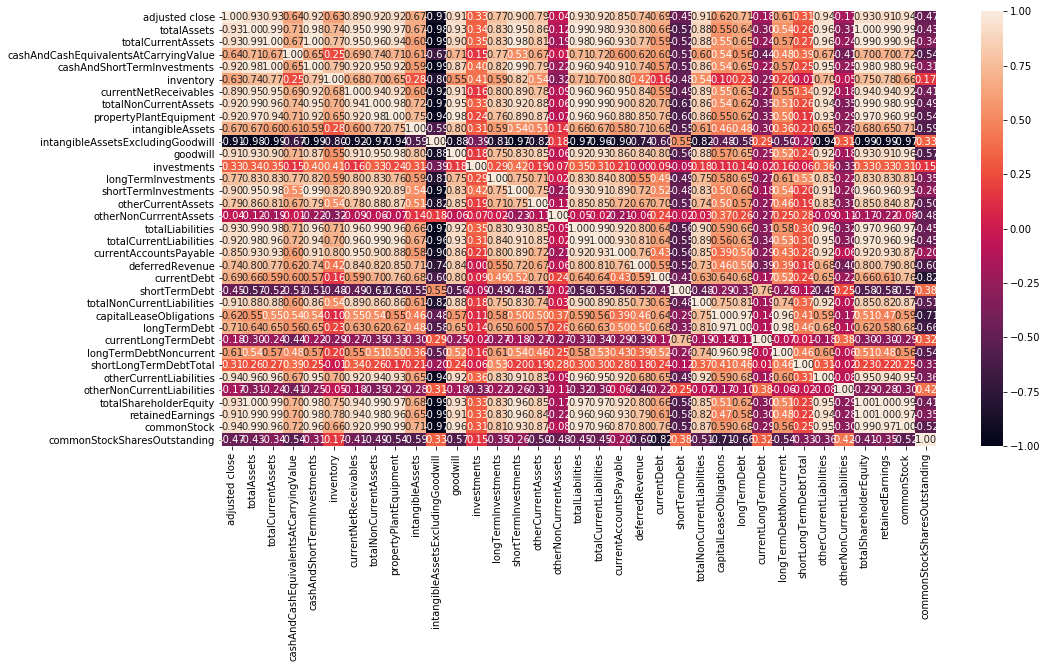

In [43]:
sb.heatmap(test.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

In [44]:
test = combine(closeData, incomeData,'timestamp','fiscalDateEnding')
test.corr()

adjusted close  grossProfit  totalRevenue  \
adjusted close                           1.000000     0.168912      0.907810   
grossProfit                              0.168912     1.000000      0.248325   
totalRevenue                             0.907810     0.248325      1.000000   
costOfRevenue                            0.914547     0.241788      0.995570   
costofGoodsAndServicesSold               0.914547     0.241788      0.995570   
operatingIncome                          0.602471     0.099020      0.734463   
sellingGeneralAndAdministrative          0.808398     0.185747      0.945654   
researchAndDevelopment                   0.887249     0.338339      0.954860   
operatingExpenses                        0.866525     0.268579      0.970752   
netInterestIncome                       -0.055526     0.131898     -0.078707   
interestIncome                           0.503813     0.130557      0.591044   
interestExpense                          0.055526    -0.131898      0.078707   
nonInterestIncome                       -0.144968    -0.566857     -0.300192   
otherNonOperatingIncome                 -0.546878    -0.045848     -0.450762   
depreciationAndAmortization              0.916634     0.239075      0.962060   
incomeBeforeTax                          0.656408     0.214043      0.771446   
incomeTaxExpense                         0.070429    -0.567805      0.045548   
interestAndDebtExpense                   0.055526    -0.131898      0.078707   
netIncomeFromContinuingOperations        0.493677     0.542329      0.605688   
comprehensiveIncomeNetOfTax              0.495047     0.562472      0.580688   
ebit                                     0.602471     0.099020      0.734463   
ebitda                                   0.727727     0.144608      0.845995   
netIncome                                0.493363     0.549682      0.604325   

                                   costOfRevenue  costofGoodsAndServicesSold  \
adjusted close                          0.914547                    0.914547   
grossProfit                             0.241788                    0.241788   
totalRevenue                            0.995570                    0.995570   
costOfRevenue                           1.000000                    1.000000   
costofGoodsAndServicesSold              1.000000                    1.000000   
operatingIncome                         0.710819                    0.710819   
sellingGeneralAndAdministrative         0.950494                    0.950494   
researchAndDevelopment                  0.960334                    0.960334   
operatingExpenses                       0.976023                    0.976023   
netInterestIncome                      -0.049172                   -0.049172   
interestIncome                          0.584799                    0.584799   
interestExpense                         0.049172                    0.049172   
nonInterestIncome                      -0.312490                   -0.312490   
otherNonOperatingIncome                -0.470330                   -0.470330   
depreciationAndAmortization             0.971320                    0.971320   
incomeBeforeTax                         0.758013                    0.758013   
incomeTaxExpense                        0.056436                    0.056436   
interestAndDebtExpense                  0.049172                    0.049172   
netIncomeFromContinuingOperations       0.587486                    0.587486   
comprehensiveIncomeNetOfTax             0.564146                    0.564146   
ebit                                    0.710819                    0.710819   
ebitda                                  0.829388                    0.829388   
netIncome                               0.586115                    0.586115   

                                   operatingIncome  \
adjusted close                            0.602471   
grossProfit                               0.099020   
totalRevenue                   

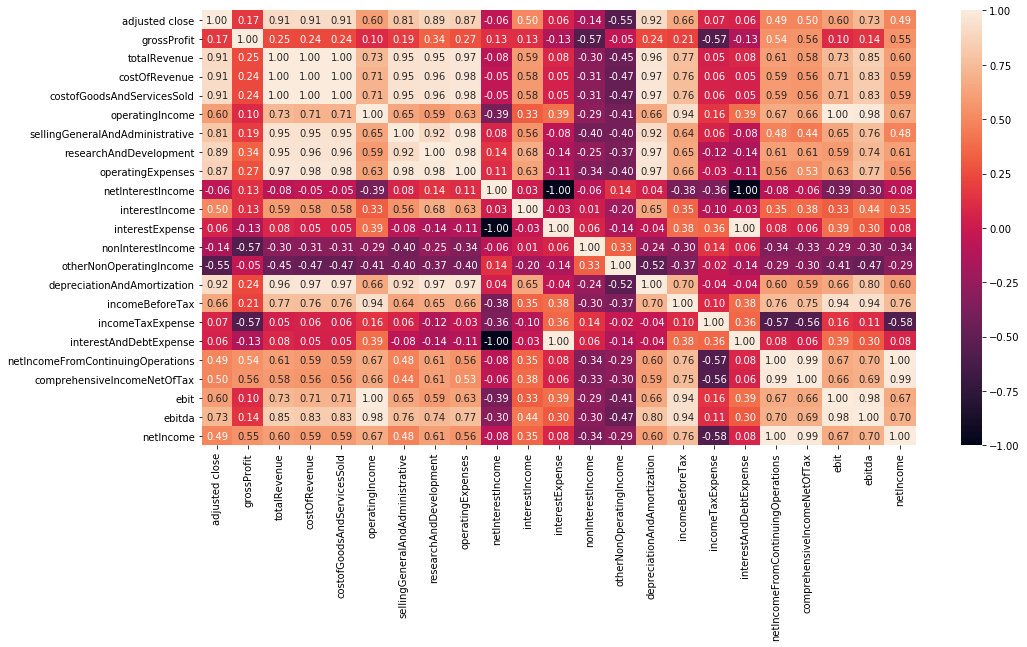

In [45]:
sb.heatmap(test.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

In [46]:
test = combine(closeData, earningsData,'timestamp','fiscalDateEnding')
test.corr()

adjusted close  reportedEPS  estimatedEPS  surprise  \
adjusted close            1.000000     0.965153      0.950443  0.612456   
reportedEPS               0.965153     1.000000      0.975863  0.664991   
estimatedEPS              0.950443     0.975863      1.000000  0.485840   
surprise                  0.612456     0.664991      0.485840  1.000000   
surprisePercentage        0.344322     0.373728      0.196893  0.822436   

                    surprisePercentage  
adjusted close                0.344322  
reportedEPS                   0.373728  
estimatedEPS                  0.196893  
surprise                      0.822436  
surprisePercentage            1.000000

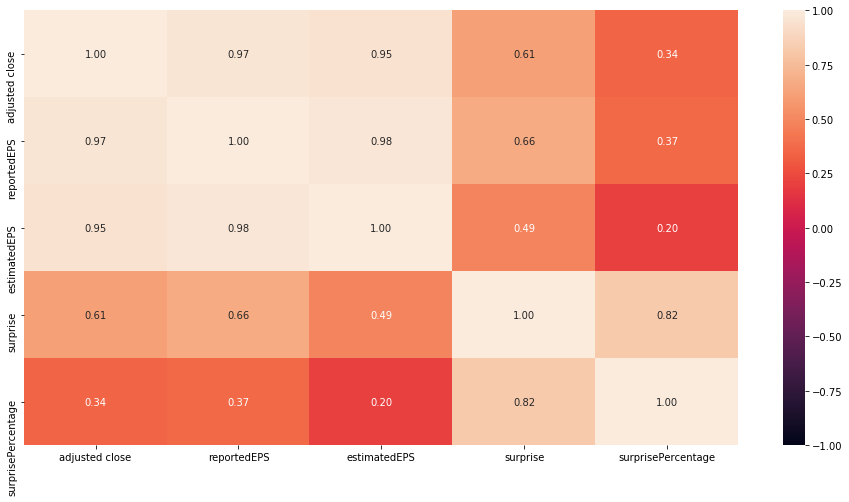

In [47]:
sb.heatmap(test.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

It seems <b>reportedEPS</b> has the <b>strongest</b> correlation to our adjusted close (0.97).

### What is this EPS?

EPS stands for earning per share. It is derived by dividing the net income of the company by the total number of shares. Since its correlation is almost a perfect positive, if we know that EPS goes up, our stock price should also follow. However, because we are dealing with timeseries, this woulnd't really help us as we would then also need to find predictors for EPS, and these predictors are also released through time. 




We can make use of a multi-variate timeseries model known as Vector Auto Regression.



# Vector Auto Regression

Vector Auto Regression(VAR) allows us to take into account lags of both the independent and dependent variable. In a sense, we are predicting adjusted close prices based on BOTH past adjusted close(its important not to neglect this) and the fundamental data we want(earnings per share)!

In [48]:
google_monthly = pd.DataFrame(monthly_data)
google_monthly.head()

timestamp      open     high        low    close  adjusted close  \
0  2021-04-20  2092.250  2304.09  2091.4300  2279.01         2279.01   
1  2021-03-31  2048.000  2113.74  1994.0000  2062.52         2062.52   
2  2021-02-26  1844.585  2145.14  1844.5850  2021.91         2021.91   
3  2021-01-29  1760.000  1932.08  1696.1014  1827.36         1827.36   
4  2020-12-31  1766.655  1843.83  1694.0000  1752.64         1752.64   

     volume  dividend amount  
0  19115877              0.0  
1  37837953              0.0  
2  33609952              0.0  
3  39569373              0.0  
4  30424255              0.0

#### Cleaning the dataset and matching quarterly EPS to monthly Google Stock Price.

In [49]:
#limit data to 2016-2019 only
google_monthly = google_monthly.iloc[15:200]
#reverse dataframe so latest date comes first
google_monthly = google_monthly[::-1]
#reindexing to start from 0
google_monthly = google_monthly.reset_index(drop=True)
#remove unwanted columns #only want timestamp and adjusted close
google_monthly.drop(columns=['open', 'high','low','close','volume','dividend amount'], inplace=True)
#google_monthly

#extract each quarter
firstQuarter = google_monthly[google_monthly['timestamp'].str.contains("-04")]
secondQuarter = google_monthly[google_monthly['timestamp'].str.contains("-07")]
thirdQuarter = google_monthly[google_monthly['timestamp'].str.contains("-10")]
fourthQuarter = google_monthly[google_monthly['timestamp'].str.contains("-01")]

#create combined dataframe of all quarters to get boeing quarterly adjusted close data
google_quarterly = pd.concat([firstQuarter, secondQuarter, thirdQuarter, fourthQuarter], axis = 0)
google_quarterly = google_quarterly.sort_values(by='timestamp',ascending=True)
google_quarterly.reset_index(drop=True, inplace=True)


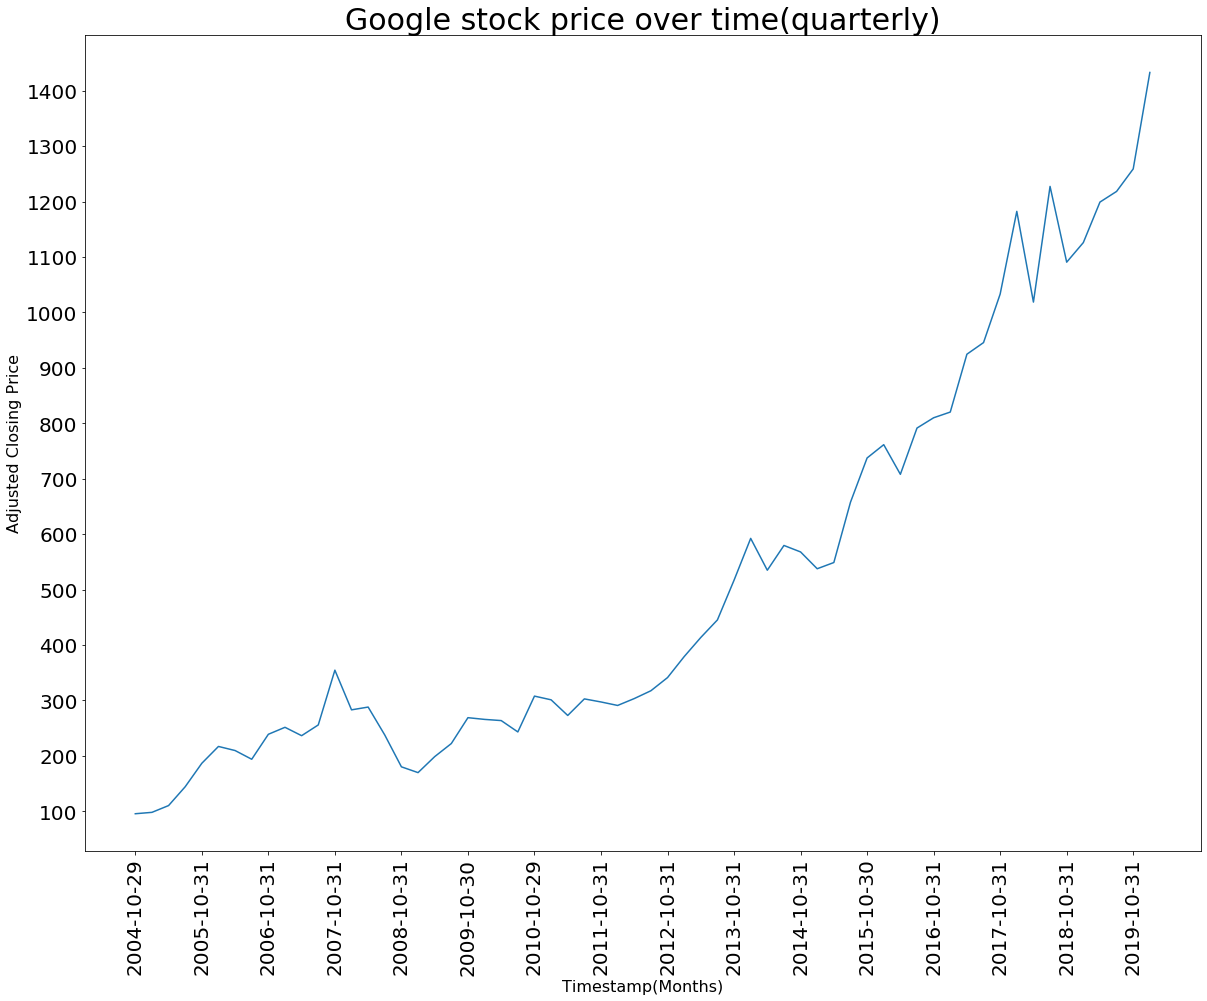

In [50]:
plt.figure(figsize=(20,15))
plt.plot(google_quarterly["timestamp"], google_quarterly["adjusted close"])
plt.yticks(np.arange(100,1500,step=100),fontsize=20)
plt.xticks(np.arange(0,61, 4), google_quarterly['timestamp'][0:61:4],rotation='vertical',fontsize=20)
plt.title("Google stock price over time(quarterly)",fontsize=30)
plt.xlabel("Timestamp(Months)",fontsize=16)
plt.ylabel("Adjusted Closing Price",fontsize=16)
plt.show()

In [51]:
with open('GOOGLEPS.json') as f:
  google_EPS = json.load(f)

#extract relevant data: quarterly earnings
google_EPS = google_EPS['quarterlyEarnings']
#convert quarterly earnings to a dataframe
google_EPS = pd.DataFrame(google_EPS)
pd.set_option('display.max_rows', 500)

#remove unwanted columns #only want estimatedEPS reportedEPS and FiscalDate
google_EPS = google_EPS[['fiscalDateEnding','reportedEPS']]
#remove unwanted rows, only want 2016-2019 data
google_EPS = google_EPS.iloc[4:66]
#reverse dataframe so latest date comes first for easier view
google_EPS = google_EPS[::-1]
#reindexing to start from 0
google_EPS = google_EPS.reset_index(drop=True)
#convert reported EPS to floating point number
google_EPS = google_EPS.astype({'reportedEPS': 'float64'})
#cleaned Fundamental data for analysis: ReportedEPS
#google_eps

google_EPS.head()

fiscalDateEnding  reportedEPS
0       2004-09-30         0.35
1       2004-12-31         0.46
2       2005-03-31         0.65
3       2005-06-30         0.68
4       2005-09-30         0.76

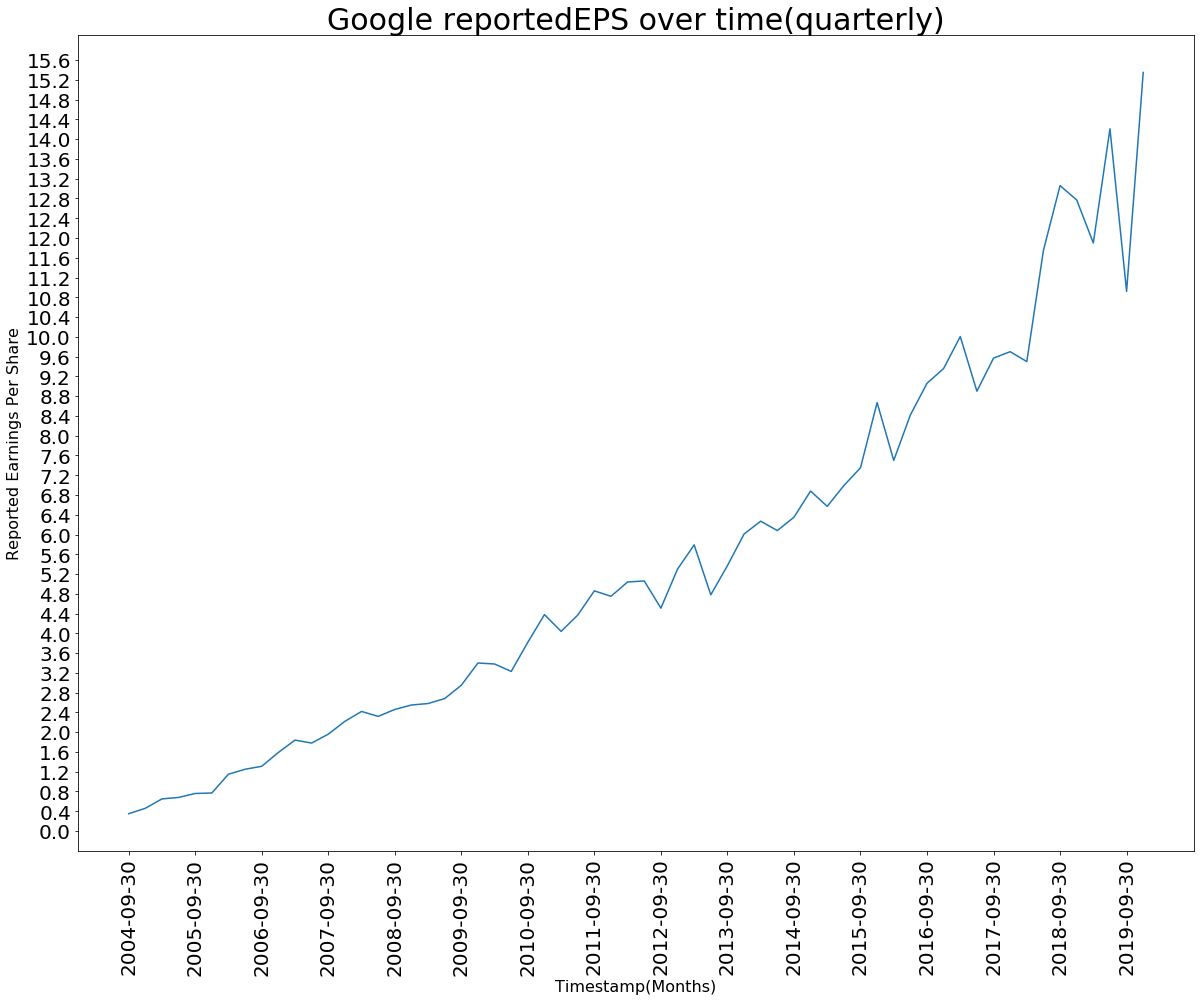

In [52]:
plt.figure(figsize=(20,15))
plt.plot(google_EPS["fiscalDateEnding"], google_EPS["reportedEPS"])
plt.yticks(np.arange(0,16,step=0.4),fontsize=20)
plt.xticks(np.arange(0,61, 4), google_EPS['fiscalDateEnding'][0:61:4],rotation='vertical',fontsize=20)
plt.title("Google reportedEPS over time(quarterly)",fontsize=30)
plt.xlabel("Timestamp(Months)",fontsize=16)
plt.ylabel("Reported Earnings Per Share",fontsize=16)
plt.show()

### Both reportedEPS and adjusted close have a fairly similar trend patterns over the years, this shows that each point in the time series influences each other. Thus, series can predicted with past values of itself along with other series. Therefore, vector autoregression can be used.

In [53]:
dataframes_list = [google_quarterly,google_EPS['reportedEPS']] # List of dataframes
df = pd.concat(dataframes_list,axis = 1) #combine all the fundamentals into a single dataframe
# drop duplicated columns, eg fiscalDateEnding or netincome as they are repeated
#pd.options.display.float_format = '{:.4f}'.format
df = df.set_index('timestamp')
df.head()

adjusted close  reportedEPS
timestamp                              
2004-10-29         95.6152         0.35
2005-01-31         98.1129         0.46
2005-04-29        110.3406         0.65
2005-07-29        144.3255         0.68
2005-10-31        186.6462         0.76

### Split the series into Training and Testing data
#### VAR model will be fitted on df_train, and 4 observations will be forecasted to be compared against actual.

In [54]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(58, 2)
(4, 2)


In [55]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### Check for stationarity and Make the time series stationary
##### VAR model requires time series to be stationary. We learn that the Augmented Dickey-Fuller Test (ADF Test) can be used to test stationarity.

In [56]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [57]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "adjusted close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.2204
 No. Lags Chosen       = 1
 Critical value 1%     = -3.553
 Critical value 5%     = -2.915
 Critical value 10%    = -2.595
 => P-Value = 0.9961. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "reportedEPS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 3.4718
 No. Lags Chosen       = 6
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




### The ADF test confirms none of the time series is stationary. So we need to difference all of them

In [58]:
# 1st difference
df_differenced = df_train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "adjusted close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2639
 No. Lags Chosen       = 0
 Critical value 1%     = -3.553
 Critical value 5%     = -2.915
 Critical value 10%    = -2.595
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "reportedEPS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4352
 No. Lags Chosen       = 1
 Critical value 1%     = -3.555
 Critical value 5%     = -2.916
 Critical value 10%    = -2.596
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




### After 1st differencing, all the series are now stationary!

### Selecting the order (P) of VAR model
#### We iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.



In [59]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  6.772546953893427
BIC :  6.9895489207579065
FPE :  873.7133091829562
HQIC:  6.856678157529193 

Lag Order = 2
AIC :  6.761238515167114
BIC :  7.126208185209382
FPE :  864.5812322321799
HQIC:  6.902375234800351 

Lag Order = 3
AIC :  6.74875486703959
BIC :  7.264417397630329
FPE :  855.5023783919702
HQIC:  6.94762568295861 

Lag Order = 4
AIC :  6.856518448886606
BIC :  7.525674193111856
FPE :  956.3870241666315
HQIC:  7.113843475054241 

Lag Order = 5
AIC :  6.931193340615337
BIC :  7.756719529245941
FPE :  1037.0804801366648
HQIC:  7.247680597768145 

Lag Order = 6
AIC :  6.838860310624341
BIC :  7.8237125939739975
FPE :  955.1289091301585
HQIC:  7.215201496732291 

Lag Order = 7
AIC :  6.994548313042813
BIC :  8.1417621162997
FPE :  1133.002797184731
HQIC:  7.431413872508948 

Lag Order = 8
AIC :  7.011031703941795
BIC :  8.323723339365495
FPE :  1177.4593233337316
HQIC:  7.509065079398919 

Lag Order = 9
AIC :  7.086158024555986
BIC :  8.567525491524734
FPE :  1

### Based on testing we, we will select lag order = 1

In [60]:
#select order 1 
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Apr, 2021
Time:                     23:49:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.98955
Nobs:                     56.0000    HQIC:                   6.85668
Log likelihood:          -342.552    FPE:                    873.713
AIC:                      6.77255    Det(Omega_mle):         787.120
--------------------------------------------------------------------
Results for equation adjusted close
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    31.261195         7.873844            3.970           0.000
L1.adjusted close        -0.304648         0.126780           -2.403           0.016
L1.reportedEPS          -33.024087 

### Forecast VAR model using statsmodel.
##### VAR model expects up to lag order number of observations from past data. (In this case 1)

In [61]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

1


array([[35.31, -0.29]])

In [62]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

adjusted close_1d  reportedEPS_1d
timestamp                                    
2019-04-30          30.081073        0.347196
2019-07-31          10.631239        0.196874
2019-10-31          21.520836        0.223914
2020-01-31          17.310383        0.222060

### Forecasts are generated based on differenced data. Hence, we need to bring it back up to original scale. 

In [63]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

### In this case, we need to "scale up" once, and there we go, the forecasts! 

In [64]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['adjusted close_forecast', 'reportedEPS_forecast']]

adjusted close_forecast  reportedEPS_forecast
timestamp                                                
2019-04-30              1155.971073             13.117196
2019-07-31              1166.602312             13.314070
2019-10-31              1188.123147             13.537983
2020-01-31              1205.433531             13.760043

In [65]:
#take adjusted close column to compare
df_results1 = df_results.reset_index(drop=True)
df_results1 = df_results1[['adjusted close_forecast']]

#take initial adjusted close data
initial_df = google_quarterly.iloc[58:62]
initial_df = initial_df.reset_index(drop=True)

#combined dataframe to show results between adjusted close predicted and actual
dataframes_list = [initial_df,df_results1]
combined_results = pd.concat(dataframes_list, axis = 1)
combined_results

timestamp  adjusted close  adjusted close_forecast
0  2019-04-30         1198.96              1155.971073
1  2019-07-31         1218.20              1166.602312
2  2019-10-31         1258.80              1188.123147
3  2020-01-31         1432.78              1205.433531

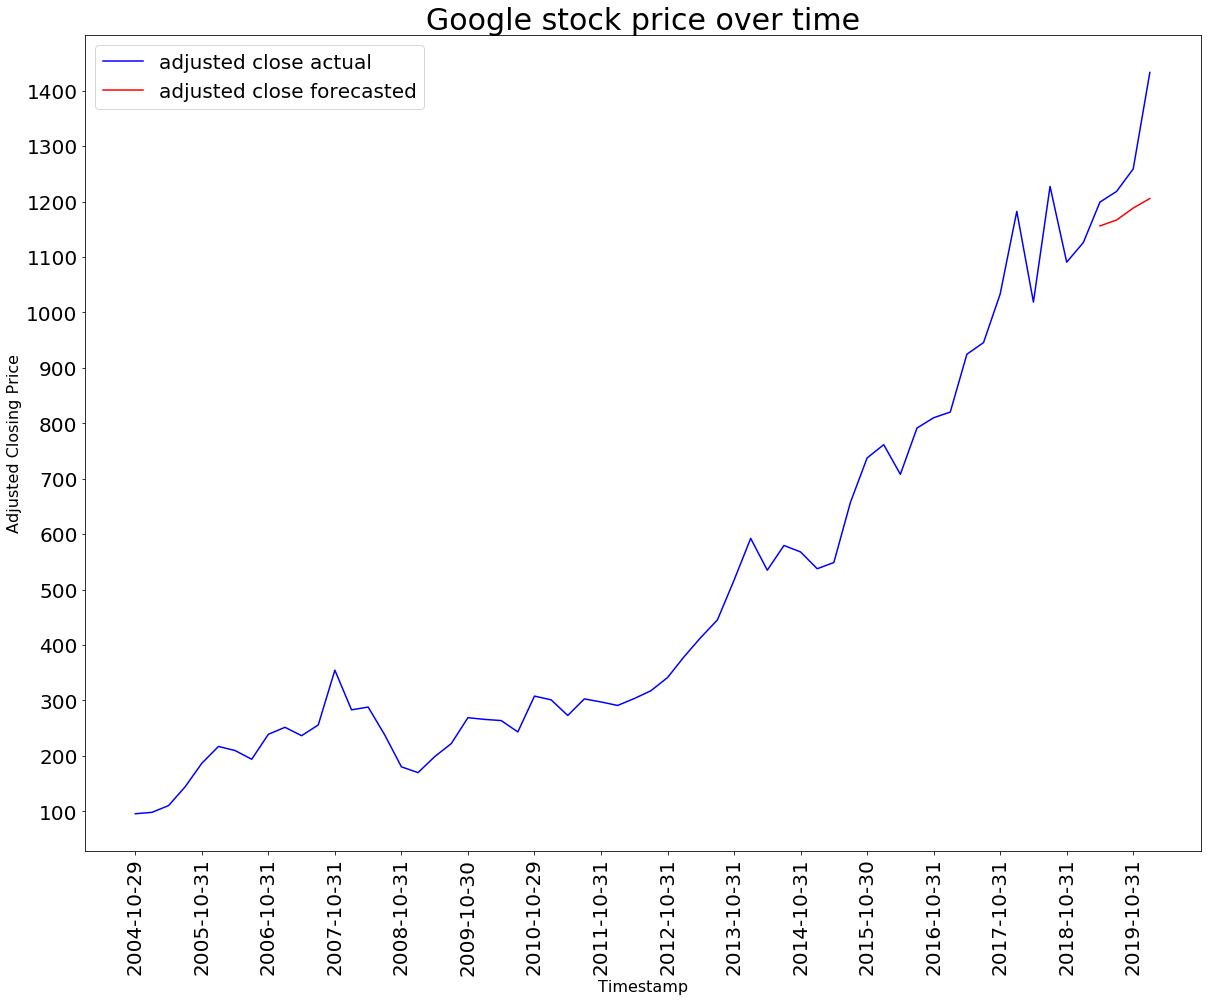

In [66]:
plt.figure(figsize=(20,15))
plt.plot(google_quarterly["timestamp"], google_quarterly["adjusted close"],color="blue",label= 'adjusted close actual')
plt.plot(combined_results["timestamp"],combined_results["adjusted close_forecast"],color="red",label= 'adjusted close forecasted')
plt.legend(fontsize = 20)
plt.yticks(np.arange(100,1500,step=100),fontsize=20)
plt.xticks(np.arange(0,61, 4), google_quarterly['timestamp'][0:61:4],rotation='vertical',fontsize=20)
plt.title("Google stock price over time",fontsize=30)
plt.xlabel("Timestamp",fontsize=16)
plt.ylabel("Adjusted Closing Price",fontsize=16)
plt.show()

### As you can see, adjusted close that was forecasted based on past EPS and past adjusted close does give some appreciable results! The upward trend is well supported. This means that Google stocks are probably good for the long term since its backed by strong company financials!

## Evaluating the Forecasts with some metrics

In [67]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: adjusted close')
accuracy_prod = forecast_accuracy(df_results['adjusted close_forecast'].values, df_test['adjusted close'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: reportedEPS')
accuracy_prod = forecast_accuracy(df_results['reportedEPS_forecast'].values, df_test['reportedEPS'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: adjusted close
mape :  0.0733
me :  -98.1525
mae :  98.1525
mpe :  -0.0733
rmse :  123.6851
corr :  0.9156
minmax :  0.0733

Forecast Accuracy of: reportedEPS
mape :  0.1272
me :  0.3373
mae :  1.5803
mpe :  0.0438
rmse :  1.7078
corr :  0.4431
minmax :  0.1132


### Around 0.08% MAPE(Mean Absolute Percentage Error) implies the model is about 92% accurate in predicting the test set observations. This is decent!

With Google(working set), it is an overall good long term investment, as price trends shown by ARIMA/LSTM with backing by fundamental datas. For the short term, depending on timeframe it may be bad, based on LSTM forecasting.

If we were not limited by the quarterly, fundamental data available on Alphavantage, perhaps we could even do VAR on other company's financials and compare the models! As even if EPS has the strongest linear correlation, it may not be the most accurate model for vector autoregression!

<br>
<br>
<br>
<br>
<br>

# Are we limited to only using timeseries forecasting models?

As we know, timeseries forecasting depends on previous datapoints to achieve an estimate of the future. What if we could use simple linear regression to predict the price?

# A case for simple linear regression

Let's say we want to refrain from using timeseries forecasting models. We can try to predict our adjusted close based on the opening price. 

In [68]:
closeDF = pd.DataFrame(monthly_data['adjusted close'])  
openingDF = pd.DataFrame(monthly_data['open'])     

Train Set : (150, 1) (150, 1)
Test Set  : (50, 1) (50, 1)


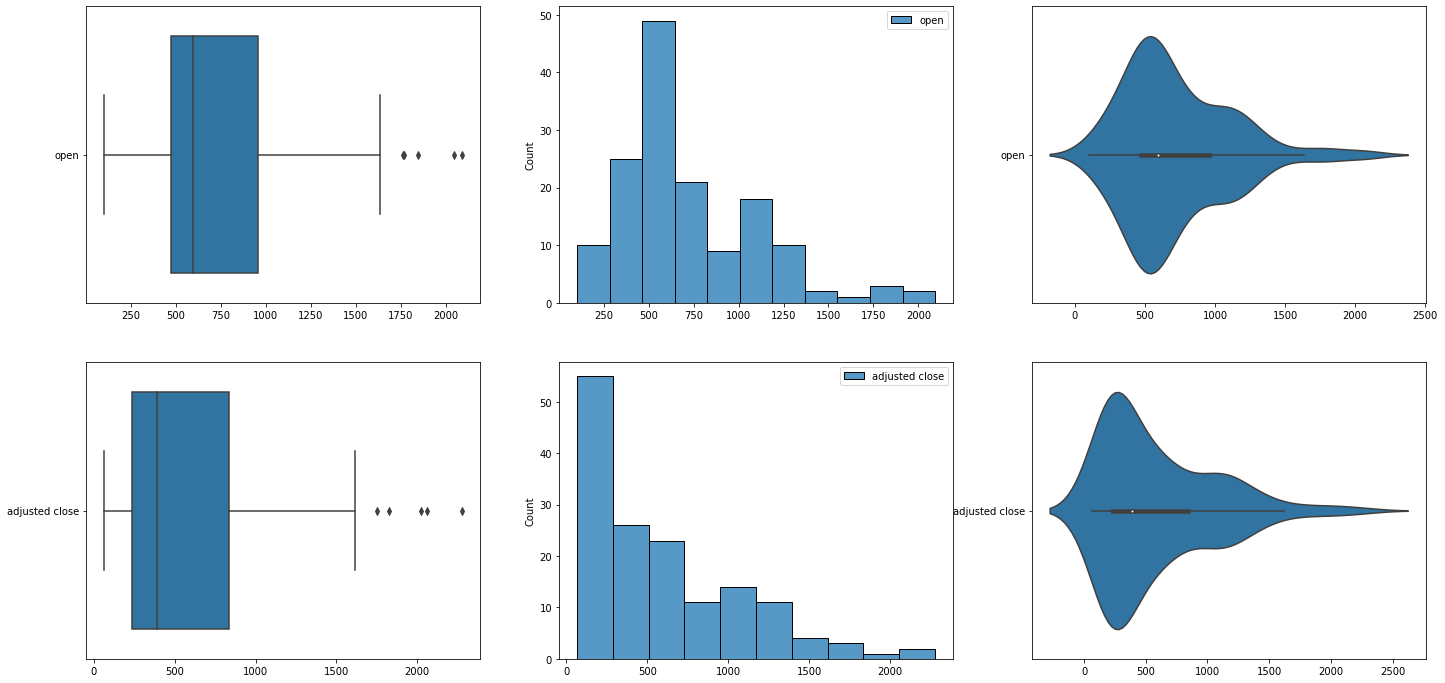

In [69]:
from sklearn.model_selection import train_test_split

open_train, open_test, close_train, close_test = train_test_split(openingDF, closeDF, test_size = 0.25)

# Check the sample sizes
print("Train Set :", open_train.shape, close_train.shape)
print("Test Set  :", open_test.shape, close_test.shape)

f, axes = plt.subplots(2, 3, figsize=(24, 12))

sb.boxplot(data = open_train, orient = "h", ax = axes[0,0])
sb.histplot(data = open_train, ax = axes[0,1])
sb.violinplot(data = open_train, orient = "h", ax = axes[0,2])

sb.boxplot(data = close_train, orient = "h", ax = axes[1,0])
sb.histplot(data = close_train, ax = axes[1,1])
sb.violinplot(data = close_train, orient = "h", ax = axes[1,2])

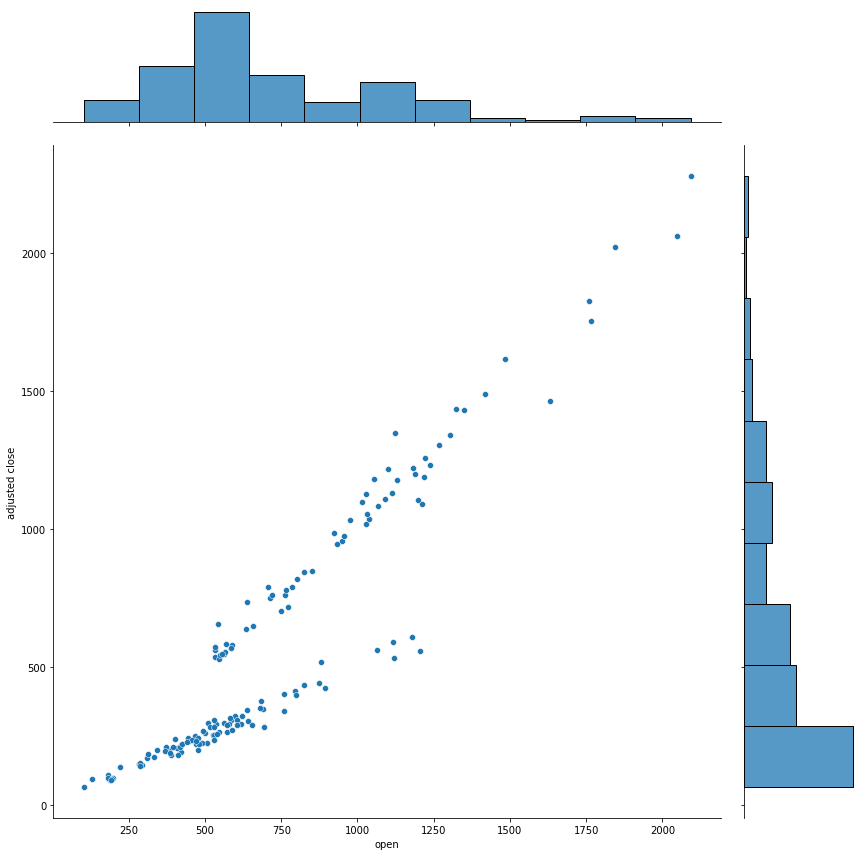

In [70]:
trainDF = pd.concat([open_train, close_train], axis = 1).reindex(open_train.index)

sb.jointplot(data = trainDF, x = "open", y = "adjusted close", height = 12)

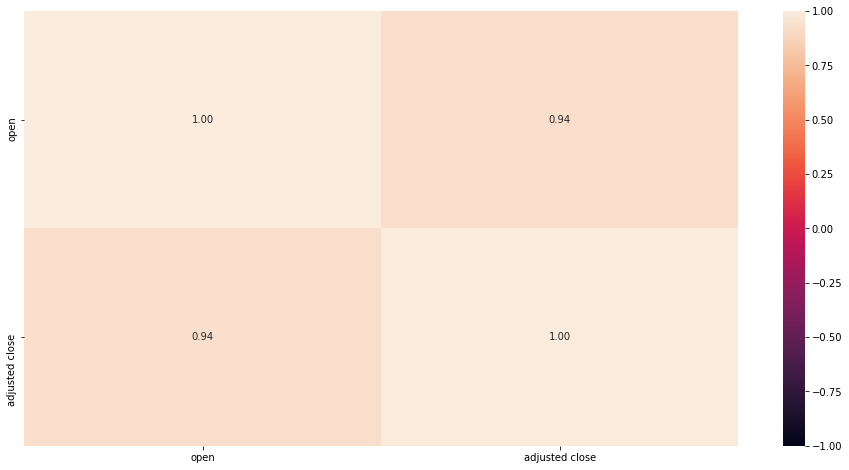

In [71]:
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

#### Wow, it seeems like the opening price has a strong correlation to our adjusted close, perfect for prediction!

In [72]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(open_train, close_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
# Coefficients of the Linear Regression line
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [-235.55850903]
Coefficients 	: a =  [[1.13630642]]


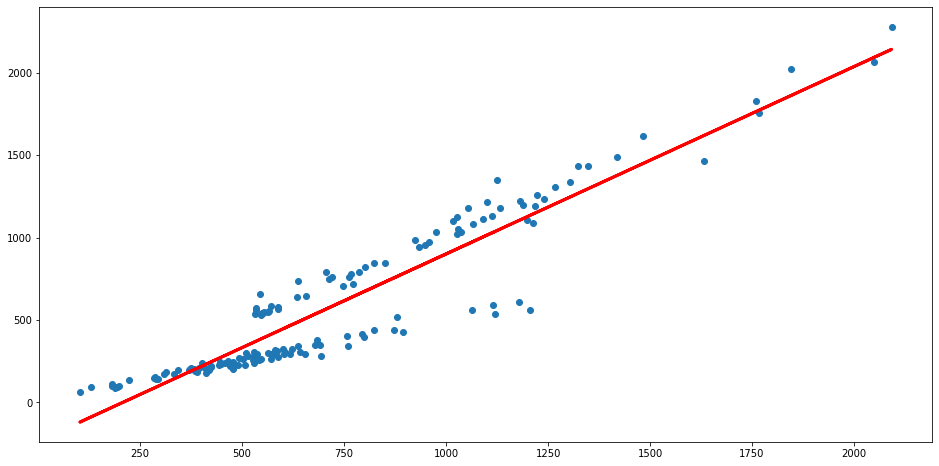

In [74]:
regline_x = open_train
regline_y = linreg.intercept_ + linreg.coef_ * open_train

f = plt.figure(figsize=(16, 8))
plt.scatter(open_train, close_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

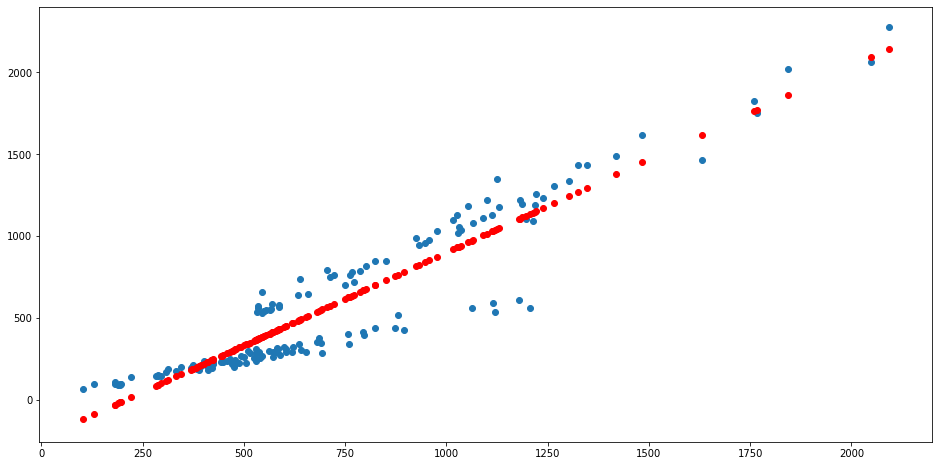

In [75]:
close_train_pred = linreg.predict(open_train)

f = plt.figure(figsize=(16, 8))
plt.scatter(open_train, close_train)
plt.scatter(open_train, close_train_pred, color = "r")
plt.show()

In [76]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(open_train, close_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(close_train, close_train_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Explained Variance (R^2) 	: 0.8755626153183419
Mean Squared Error (MSE) 	: 27090.336014515175
Root Mean Squared Error (RMSE) 	: 164.59142144873522


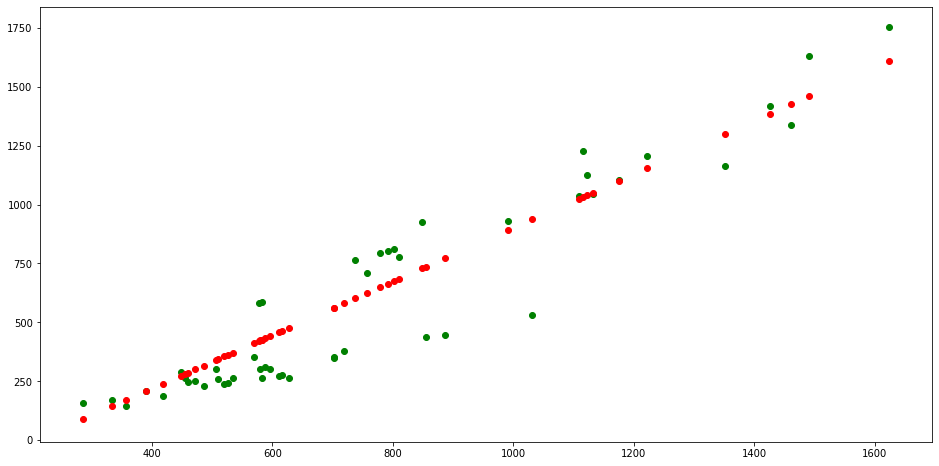

In [77]:
close_test_pred = linreg.predict(open_test)

f = plt.figure(figsize=(16, 8))
plt.scatter(open_test, close_test, color = "green")
plt.scatter(open_test, close_test_pred, color = "red")
plt.show()

In [78]:
print("Explained Variance (R^2) \t:", linreg.score(open_test, close_test))
mse = mean_sq_err(close_test, close_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Explained Variance (R^2) 	: 0.8822246634301374
Mean Squared Error (MSE) 	: 21378.142356634795
Root Mean Squared Error (RMSE) 	: 146.21266141013504


#### Looks like our prediction test is doing well. Let's try predicting adjusted closes with some opening prices!

In [79]:
candlestick_figure(monthly_data)

In [80]:
predictors = pd.DataFrame(monthly_data[['open']])
predictors = predictors.iloc[0:3]
predictors.head()

predicted_close = linreg.predict(predictors)
predicted_close

array([[2141.87860625],
       [2091.597047  ],
       [1860.45527579]])

In [81]:
monthly_data.head()

timestamp      open     high        low    close  adjusted close  \
0  2021-04-20  2092.250  2304.09  2091.4300  2279.01         2279.01   
1  2021-03-31  2048.000  2113.74  1994.0000  2062.52         2062.52   
2  2021-02-26  1844.585  2145.14  1844.5850  2021.91         2021.91   
3  2021-01-29  1760.000  1932.08  1696.1014  1827.36         1827.36   
4  2020-12-31  1766.655  1843.83  1694.0000  1752.64         1752.64   

     volume  dividend amount  
0  19115877              0.0  
1  37837953              0.0  
2  33609952              0.0  
3  39569373              0.0  
4  30424255              0.0

In [82]:
# Summary of prediction and errors

for i in monthly_data.index:
    if(i>=3):
        break
        
    print('Timestamp:{}  opening:{}  actual close:{}  predicted close:{}  error{}'.format(monthly_data['timestamp'][i],monthly_data['open'][i],monthly_data['adjusted close'][i],predicted_close[i],abs(monthly_data['adjusted close'][i]-predicted_close[i])))


Timestamp:2021-04-20  opening:2092.25  actual close:2279.01  predicted close:[2141.87860625]  error[137.13139375]
Timestamp:2021-03-31  opening:2048.0  actual close:2062.52  predicted close:[2091.597047]  error[29.077047]
Timestamp:2021-02-26  opening:1844.585  actual close:2021.91  predicted close:[1860.45527579]  error[161.45472421]


The results are decent, it seems accurate but can we really predict closing prices based on opening prices without factoring lags? A linear regression model is an example of an over simplistic model. 
Furthermore, correlation doesn't imply causality!

<br><br>

# Conclusion

Stock prices are heavily influenced by other factors like: competitors, bad press, insider trading, product releases, etc...


As such, we cannot solely depend on price points to determine the future closing prices. In fact, timeseries itself isn't easy to predict, otherwise we would all be driving lambos. However, this is not to say that we cannot achieve predictions based on the past.


Fundamental data is important to help us understand the financial of the company, which is the best way to determine under-priced investments. Determining stock prices purely based on market prices may be subjected to shocks, thus using fundamentals can help make a more informed decision. In Google’s case, the price trend is supported by fundamentals, making Google viable in the long run.


The predictions require the use of timeseries forecasting models. Simple linear regression won't cut it as the predictors themselves also require predicting and only past values can help us estimate the future values. The only variable that can act as a predictor for linear regression is the opening price, because the opening price stays fixed in a particualar timeframe before resetting when a new closing price is revealed.


Time Series models like ARIMA can help us estimate the future price based on past prices. However, ARIMA model is limited in univariate analysis and only gives a general trend. If more fundamental data was available(like earnings per share), we can perform VAR on more variables to generate a better stock price prediction. A step up to that would be recurrent neural networks like LSTM which can 'remember' all the past prices and give us a more accurate prediction. LSTM will outperform ARIMA when it has more data.


Hence, such models can only aim to help make an informed decision but an individual still needs to factor in other variables which these models cannot. 


References:<br>
https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima 
https://towardsdatascience.com/multivariate-time-series-forecasting-456ace675971 
https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7 
https://towardsdatascience.com/forecasting-teslas-stock-price-using-autoregression-52e7908d34b6 
https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html 
https://machinelearningmastery.com/make-manual-predictions-arima-models-python/ 
https://machinelearningmastery.com/make-sample-forecasts-arima-python/ 
https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py
https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
https://towardsdatascience.com/how-to-use-data-science-on-the-stock-market-9d97a4d348d6 